In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import math
from statsmodels.nonparametric.smoothers_lowess import lowess 

# Read the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\zhang\seadrive_root\Sha.Zhan\My Libraries\aPhD Papers\热浪\2021 年热浪实验\2021 heat waves rice data.csv')

# Extract the specified columns
new_df = df[['Mean_VPD','Max_T','Mean_RH','Exetreme_DAYS>31.4', 'Exetreme_DAYS>36','wt per grain', 'tAsp','As 75 ug kg-1']]

# Drop rows with NaN values
new_df_dropped = new_df.dropna()

# Define the X and y variables for further modeling
X = new_df_dropped[['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_RH']]
y = new_df_dropped['As 75 ug kg-1']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Hyperparameter optimization using RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2],
    'lambda': [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=54752075),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=54752075),
    verbose=2,
    random_state=54752075,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Define and train the XGBoost model with the best parameters
best_learner = XGBRegressor(random_state=54752075, **best_params)
best_learner.fit(X_train, y_train)

# Make predictions on the test set
best_prediction = best_learner.predict(X_test)
# Calculate RMSE
rmse = mean_squared_error(y_test, best_prediction, squared=False)

# Print R-squared, Accuracy, MAE, and RMSE values
print('R2 Value_train:', metrics.r2_score(y_train, best_learner.predict(X_train)))
print('R2 Value_test:', metrics.r2_score(y_test, best_learner.predict(X_test)))
accuracy = 100 - (np.mean(np.abs((y_test - best_prediction) / y_test)) * 100)
print('Accuracy:', accuracy)
print('MAE_train:', metrics.mean_absolute_error(y_train, best_learner.predict(X_train)))
print('MAE_test:', metrics.mean_absolute_error(y_test, best_learner.predict(X_test)))
MSE_train = np.square(np.subtract(y_train, best_learner.predict(X_train))).mean()
MSE_test = np.square(np.subtract(y_test, best_learner.predict(X_test))).mean()
RMSE_train = math.sqrt(MSE_train)
RMSE_test = math.sqrt(MSE_test)
print('RMSE_train:', RMSE_train)
print('RMSE_test:', RMSE_test)

# Create a DataFrame with prediction and observation values
results = pd.DataFrame({'Observation': y_test, 'Prediction': best_prediction})

# Print the DataFrame and RMSE
#print(results)
print(f"RMSE: {rmse:.4f}")
# Save the DataFrame as a CSV file
results.to_csv('prediction_results.csv', index=False)

C:\Users\zhang\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Fitting 100 folds for each of 50 candidates, totalling 5000 fits
Best Parameters:
subsample: 1.0
n_estimators: 100
max_depth: 3
learning_rate: 0.2
lambda: 0
gamma: 0.2
colsample_bytree: 0.8
alpha: 0.2
R2 Value_train: 0.9970374907661199
R2 Value_test: 0.9081215125157986
Accuracy: 83.02658117303439
MAE_train: 35.37379270929452
MAE_test: 77.6305580269336
RMSE_train: 46.14911999172697
RMSE_test: 118.74039119167966
RMSE: 118.7404


26530.0000298186


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


100233.60806329225
76039.10326071801


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
invalid value encountered in divide


662.3751496331342


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
invalid value encountered in divide


1478.9239128355812


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


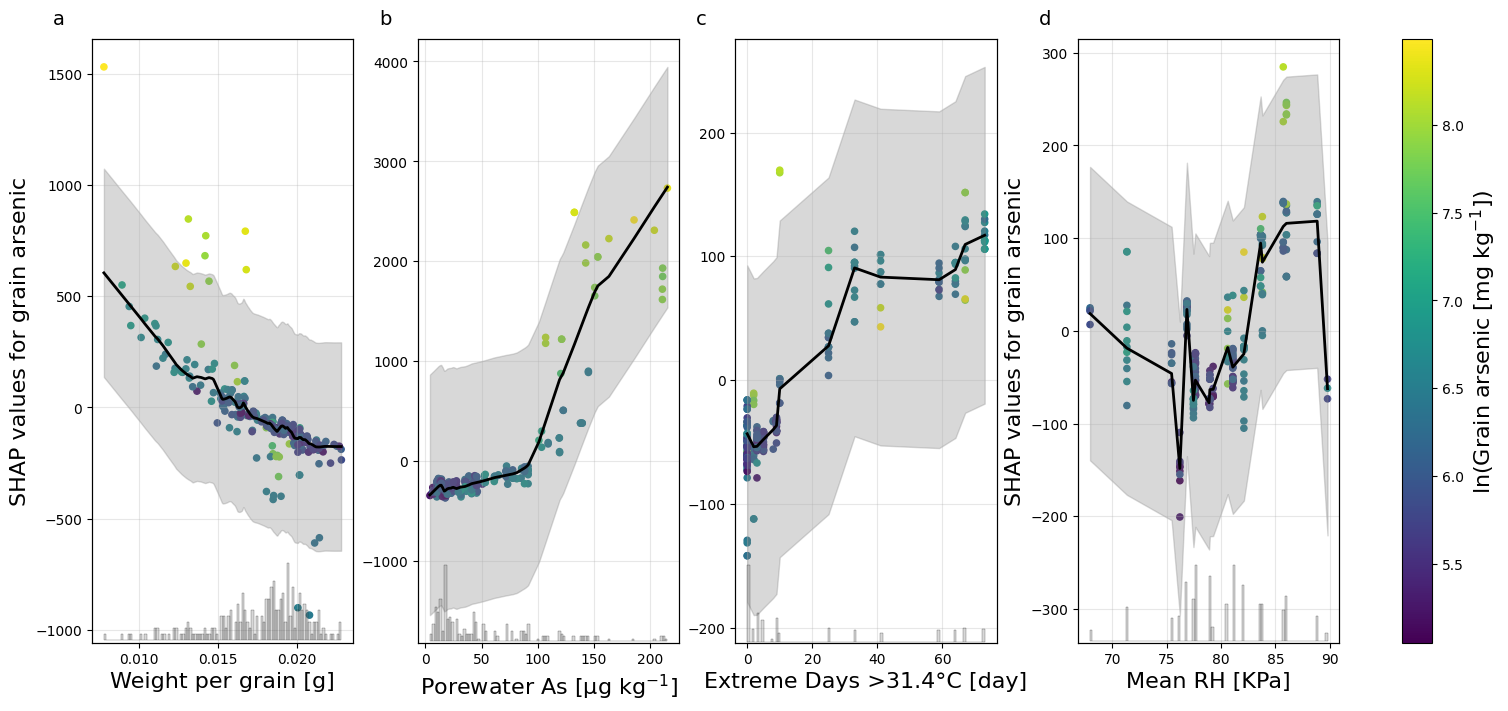

In [2]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import string
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm
from sklearn.model_selection import KFold

# Compute the SHAP values for the input features,'Max_T':2, 'Mean_RH':2,'Exetreme_DAYS>33':2
shap_values = shap.TreeExplainer(best_learner).shap_values(X)
# Create a DataFrame with the SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Merge the 'Treatment' feature with the SHAP values DataFrame
#merged_df = pd.merge(df[['Treatment']], shap_df, left_index=True, right_index=True)
#print(merged_df)
# Extract 'wt per grain' and 'As 75 ug kg-1' columns into a new DataFrame
selected_columns = ['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_RH','As 75 ug kg-1']
selected_df = df[selected_columns]
# Remove rows containing NaN values in the selected columns
selected_df = selected_df.dropna()
# Define the format labels for each feature
formats = {
    'wt per grain': 'Weight per grain [g]',
    'tAsp': 'Porewater As [$\mathrm{\mu}$g kg$^{-1}$]',
    'Exetreme_DAYS>36': 'Extreme Days >31.4°C [day]',
    'Mean_RH': 'Mean RH [KPa]',
}
# Create a figure with subplots for each feature
fig, axs = plt.subplots(nrows=1, ncols=len(['tAsp', 'wt per grain','Exetreme_DAYS>36','Mean_RH']), 
                        figsize=(15, 7), constrained_layout=True)
#,'Exetreme_DAYS>33','Mean_VPD','Mean_RH'

def calculate_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

for i, feature in enumerate(['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_RH']):
    
    if i % len(['wt per grain', 'tAsp','Exetreme_DAYS>36']) == 0:
        axs[i].set_ylabel('SHAP values for grain arsenic', fontsize=16)
         
    axs[i].grid(True, alpha=0.3)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)
    axs[i].text(-0.15, 1.05, string.ascii_lowercase[i], transform=axs[i].transAxes, fontsize=14, va='top')
    
    
    best_lowess_fit = None
    best_mse = float('inf')  # Initialize with a large value
    # Define the smoothing parameters to try
    smoothing_params = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
    for smoothing_param in smoothing_params:
        mse_scores = []
        for train_idx, val_idx in KFold(n_splits=10, shuffle=True).split(X[feature]):
            X_train, X_val = X[feature].iloc[train_idx], X[feature].iloc[val_idx]
            y_train, y_val = shap_df[feature].iloc[train_idx], shap_df[feature].iloc[val_idx]
            
            # Create scatter plot with Lowess regression line
            #the optimized one is frac=0.5, however, there are many noises, so i used a 
            lowess_fit = lowess(y_train, X_train, frac=smoothing_param)
            
            # Calculate mean squared error for the validation set
            y_pred = np.interp(X_val, lowess_fit[:, 0], lowess_fit[:, 1])
            mse = calculate_mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)
        
        avg_mse = np.mean(mse_scores)
        
        # Store the Lowess fit for the best mean squared error
        if avg_mse < best_mse:
            best_lowess_fit = lowess_fit
            best_mse = avg_mse
            print (best_mse)
    
    # Plot the best Lowess fit for the current feature
    selected_df['As 75 ug kg-1_log'] = np.log(selected_df['As 75 ug kg-1'])
    axs[i].plot(best_lowess_fit[:, 0], best_lowess_fit[:, 1], color='black', linestyle='-', alpha=1, linewidth=2, 
                label='Optimized Lowess (Avg MSE {:.2f})'.format(best_mse))
    scatter = axs[i].scatter(X[feature], shap_df[feature],  c=selected_df['As 75 ug kg-1_log'],cmap='viridis', alpha=1, s=20)
    axs[i].fill_between(best_lowess_fit[:, 0], best_lowess_fit[:, 1] - 1.96 * np.std(shap_df[feature]), 
                        best_lowess_fit[:, 1] + 1.96 * np.std(shap_df[feature]), color='gray', alpha=0.3, label='95% CI')
    axs[i].set_xlabel(formats[feature], fontsize=16)
    
    # Create histogram and KDE plot on separate axes with a secondary y-axis
    ax_hist = axs[i].twinx()
    sns.histplot(X[feature], ax=ax_hist, color='gray', alpha=0.3, bins=100, kde=False)
    #sns.kdeplot(X[feature], ax=ax_hist, color='red', alpha=0.5, linewidth=2)
    ax_hist.set_yticks([])
    #ax_hist.set_ylabel('Density', fontsize=16)
    ax_hist.yaxis.tick_right()
    #ax_hist.yaxis.set_label_position("right")
    #ax_hist.spines['right'].set_position(('axes', 1.1))
    ax_hist.set_ylim(-0.5, ax_hist.get_ylim()[1] * 7.5)
    # hide the ticks of the secondary y-axis
    ax_hist.set_yticks([])
    ax_hist.yaxis.label.set_text('')
    
# Add a gradient colorbar for all subplots
cbar = fig.colorbar(scatter, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('ln(Grain arsenic [mg kg$^{-1}$])', fontsize=16)

# Set the space between subplots
plt.subplots_adjust(wspace=0.3)
plt.savefig('As_wt_per_grain_33.tif', dpi=1200, bbox_inches='tight')
plt.show()

In [24]:
import numpy as np

# Calculate the squared SHAP values for each feature
shap_values_squared = shap_values ** 2

# Sum up the squared SHAP values for each feature
total_explained_variance = np.sum(shap_values_squared, axis=0)

# Calculate the proportion of explained variance for each feature
proportion_explained_variance = total_explained_variance / np.sum(total_explained_variance)*90.9226044376909

# List of feature names
feature_names = ['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_RH']  # Add your feature names here

# Number of bootstrap samples
num_bootstrap_samples = 1000  # You can adjust this value based on your needs

# List to store bootstrap samples of proportions of explained variance
bootstrap_samples = []

# Perform bootstrapping
for _ in range(num_bootstrap_samples):
    # Randomly sample indices with replacement
    indices = np.random.choice(range(shap_values_squared.shape[0]), size=shap_values_squared.shape[0], replace=True)
    
    # Calculate the total explained variance for the bootstrap sample
    bootstrap_total_explained_variance = np.sum(shap_values_squared[indices], axis=0)
    
    # Calculate the proportion of explained variance for the bootstrap sample
    bootstrap_proportion_explained_variance = bootstrap_total_explained_variance / np.sum(bootstrap_total_explained_variance)*90.9226044376909
    
    # Append the bootstrap sample to the list
    bootstrap_samples.append(bootstrap_proportion_explained_variance)

# Convert the list of bootstrap samples to a NumPy array
bootstrap_samples = np.array(bootstrap_samples)

# Calculate the lower and upper percentiles for the confidence interval
confidence_interval_lower = np.percentile(bootstrap_samples, 2.5, axis=0)
confidence_interval_median = np.percentile(bootstrap_samples, 50, axis=0)
confidence_interval_upper = np.percentile(bootstrap_samples, 97.5, axis=0)

# Print out the confidence intervals for each feature
   
for feature, lower,median, upper, proportion in zip(feature_names, confidence_interval_lower,confidence_interval_median,
                                                    confidence_interval_upper,proportion_explained_variance):
    print(f"{feature},Mean:{proportion:.1f} [{lower:.1f},{median:.1f}, {upper:.1f}]")


wt per grain,Mean:11.5 [8.1,11.3, 15.7]
tAsp,Mean:77.2 [72.6,77.4, 80.6]
Exetreme_DAYS>36,Mean:1.0 [0.7,1.0, 1.4]
Mean_RH,Mean:1.2 [0.9,1.2, 1.7]


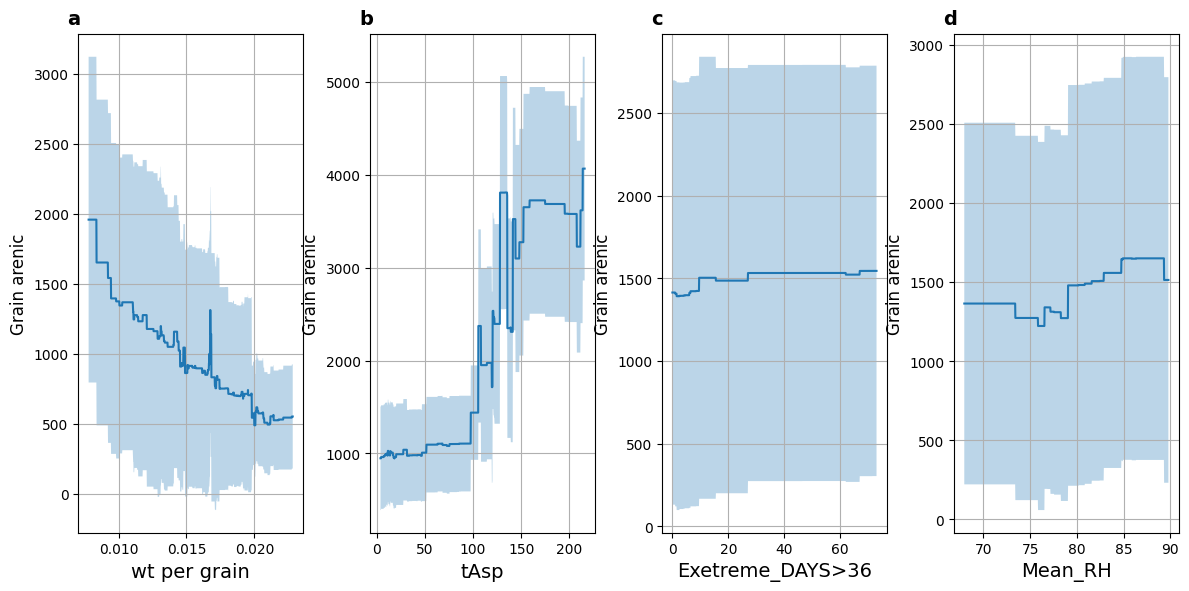

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the features of interest
#features_of_interest = ['TS_2', 'NEE', 'VPD', 'R_REDOX']
features_of_interest = ['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_RH']

# Define the format for each feature
formats = {    "wt per grain": "wt per grain",
    "tAsp": "tAsp",
    "Exetreme_DAYS>36": "Exetreme_DAYS>36",
           "Mean_RH":"Mean_RH"
}

# 'wt per grain': 'Weight per grain [g]',
# Select a subset of data with the features of interest and other relevant features
subset_data = df[["As 75 ug kg-1"] + features_of_interest]

# Fix the values of other features (e.g., 'Feature_Y' and 'Feature_Z')
fixed_feature_values = {
     'wt per grain': subset_data['wt per grain'].median(),
    'tAsp': subset_data['tAsp'].median(),
    'Exetreme_DAYS>36': subset_data['Exetreme_DAYS>36'].median(),
    'Mean_RH': subset_data['Mean_RH'].median(),
}

# Create subplots for each feature
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs = axs.ravel()

# Inside the loop
for i, feature_of_interest in enumerate(features_of_interest):
    # Calculate predictions for the subset data while varying the current feature
    predictions = []
    uncertainty = []
    feature_values_range = np.linspace(subset_data[feature_of_interest].min(), subset_data[feature_of_interest].max(), 1000)
    
    for feature_value in feature_values_range:
        # Create a copy of the original subset_data to avoid modifying it in place
        subset_data_copy = subset_data.copy()
        # Set the current feature values in the copy
        subset_data_copy.loc[:, feature_of_interest] = feature_value
        # Make predictions using your model (e.g., XGBoost) on the copy
        subset_predictions = best_learner.predict(subset_data_copy[features_of_interest])
        # Append the predictions
        predictions.append(subset_predictions.mean())
        # Calculate uncertainty (e.g., standard deviation) on the copy
        uncertainty.append(subset_predictions.std())
    
    # Create a partial relationship plot with uncertainty for the current feature
    axs[i].plot(feature_values_range, predictions, linestyle='-', label='')
    axs[i].fill_between(feature_values_range, np.array(predictions) - np.array(uncertainty), 
                        np.array(predictions) + np.array(uncertainty), alpha=0.3, label='')
    axs[i].set_xlabel(formats[feature_of_interest], fontsize=14)  # Use the formatted label
    axs[i].set_ylabel('Grain arenic', fontsize=12)
    #axs[i].set_title(f'Partial Relationship Plot for {formats[feature_of_interest]} with Uncertainty', fontsize=12)  # Use the formatted title
    # Add a label to the top-left corner of each subplot
    axs[i].text(-0.05, 1.05, chr(97+i), transform=axs[i].transAxes, fontsize=14, fontweight='bold', va='top')
    #axs[i].legend()
    axs[i].grid(True)
# Adjust subplot layout
plt.tight_layout()

# Set the space between subplots
plt.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.savefig('Grain arsenic prediction.tif', dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import mean_squared_error
import math
import optuna

# Load your data
df = pd.read_csv(r'merged_gas_flux_data_HH.csv', low_memory=False)

# Select the features and target variable
X = df[['TS_2', 'NEE', 'VPD', 'R_REDOX']]
y = df['FCH4']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 8, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 0.95),
        'gamma': trial.suggest_uniform('gamma', 0, 0.5),
        'alpha': trial.suggest_uniform('alpha', 0, 1),
        'lambda': trial.suggest_uniform('lambda', 0, 1)
    }

    xgb_reg = XGBRegressor(**params, random_state=54752075)
    rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=54752075)

    scores = []
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        xgb_reg.fit(X_train_fold, y_train_fold)
        val_pred = xgb_reg.predict(X_val_fold)
        score = mean_squared_error(y_val_fold, val_pred, squared=False)
        scores.append(score)

    return np.mean(scores)

# Perform hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params
print("Best Parameters:")
print(best_params)

# Train the model with the best parameters
best_learner = XGBRegressor(**best_params, random_state=54752075)
best_learner.fit(X_train, y_train)

# Make predictions on the test set
best_prediction = best_learner.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, best_prediction, squared=False)
print("RMSE:", rmse)


[I 2024-09-16 16:42:34,642] A new study created in memory with name: no-name-a8dc1b73-fe2f-4774-b9be-89d522fe3471
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_

[I 2024-09-16 16:43:25,635] Trial 5 finished with value: 129.05074629857694 and parameters: {'learning_rate': 0.07443215992470571, 'n_estimators': 728, 'max_depth': 10, 'subsample': 0.5528305433447447, 'colsample_bytree': 0.6235888088908021, 'gamma': 0.14037679836328193, 'alpha': 0.29312004353243326, 'lambda': 0.030219234365796432}. Best is trial 3 with value: 107.821963125485.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[I 2024-09-16 16:44:09,309] Trial 11 finished with value: 107.89027846226469 and parameters: {'learning_rate': 0.023797692294908922, 'n_estimators': 553, 'max_depth': 8, 'subsample': 0.5065511602444012, 'colsample_bytree': 0.8519513570852114, 'gamma': 0.3011729695042457, 'alpha': 0.23051605904236824, 'lambda': 0.6036783092002007}. Best is trial 6 with value: 105.19255859573263.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0

[I 2024-09-16 16:44:47,848] Trial 17 finished with value: 106.51449297689166 and parameters: {'learning_rate': 0.010006035650376645, 'n_estimators': 817, 'max_depth': 8, 'subsample': 0.51012788575453, 'colsample_bytree': 0.7196615952519619, 'gamma': 0.3597962162072625, 'alpha': 0.3521374211404541, 'lambda': 0.49840175699005174}. Best is trial 6 with value: 105.19255859573263.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

[I 2024-09-16 16:45:24,842] Trial 23 finished with value: 105.75035943722808 and parameters: {'learning_rate': 0.01311565915990782, 'n_estimators': 637, 'max_depth': 5, 'subsample': 0.546352940553637, 'colsample_bytree': 0.7684574889446493, 'gamma': 0.30123062975692455, 'alpha': 0.11823635171439395, 'lambda': 0.7985418433983781}. Best is trial 6 with value: 105.19255859573263.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

[I 2024-09-16 16:45:56,118] Trial 29 finished with value: 105.34686838945628 and parameters: {'learning_rate': 0.022986231792263577, 'n_estimators': 505, 'max_depth': 4, 'subsample': 0.504087270586418, 'colsample_bytree': 0.6541051781472141, 'gamma': 0.4932333717900984, 'alpha': 0.002430859150185871, 'lambda': 0.5014311948736903}. Best is trial 28 with value: 103.30818172919975.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[I 2024-09-16 16:46:23,951] Trial 35 finished with value: 104.64385359174656 and parameters: {'learning_rate': 0.015529083418129539, 'n_estimators': 600, 'max_depth': 4, 'subsample': 0.5532046344078926, 'colsample_bytree': 0.6301877634653803, 'gamma': 0.42922459491353976, 'alpha': 0.8642025781994214, 'lambda': 0.4528281259688151}. Best is trial 28 with value: 103.30818172919975.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[I 2024-09-16 16:47:03,642] Trial 41 finished with value: 107.96511787387016 and parameters: {'learning_rate': 0.015719485661435, 'n_estimators': 995, 'max_depth': 4, 'subsample': 0.5234506249773587, 'colsample_bytree': 0.669488847406865, 'gamma': 0.3789949923275393, 'alpha': 0.0979836703493755, 'lambda': 0.5068640386061519}. Best is trial 28 with value: 103.30818172919975.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[I 2024-09-16 16:47:29,963] Trial 47 finished with value: 102.54427915986828 and parameters: {'learning_rate': 0.011193523147975181, 'n_estimators': 549, 'max_depth': 4, 'subsample': 0.5806667863482236, 'colsample_bytree': 0.6179456256268018, 'gamma': 0.4936862008151065, 'alpha': 0.007078765575369378, 'lambda': 0.8830391620611333}. Best is trial 47 with value: 102.54427915986828.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0

Best Parameters:
{'learning_rate': 0.011193523147975181, 'n_estimators': 549, 'max_depth': 4, 'subsample': 0.5806667863482236, 'colsample_bytree': 0.6179456256268018, 'gamma': 0.4936862008151065, 'alpha': 0.007078765575369378, 'lambda': 0.8830391620611333}
RMSE: 105.2647
    Soil  wt per grain       tAsp  Mean_RH  Max_T  As 75 ug kg-1
14    XC      0.015191  45.602633    80.61  34.95     733.369955
15    XC      0.013056  45.602633    80.61  34.95     745.383054
19    XC      0.016560  85.134524    80.61  34.95     658.853408
20    XC      0.016082  85.134524    80.61  34.95     658.537199
24    XC      0.014727  73.326067    80.61  34.95     626.369641
..   ...           ...        ...      ...    ...            ...
522  YCH      0.015243  14.159274    81.08  31.48     436.974703
523  YCH      0.016327  14.159274    81.08  31.48     425.365972
524  YCH      0.018347  14.255920    81.08  31.48     392.682594
525  YCH      0.011093  88.307278    81.08  31.48     898.528445
526  YCH     


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


271.19597412892085



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
invalid value encountered in divide


163.33283641342612



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
The figure layout has changed to tight


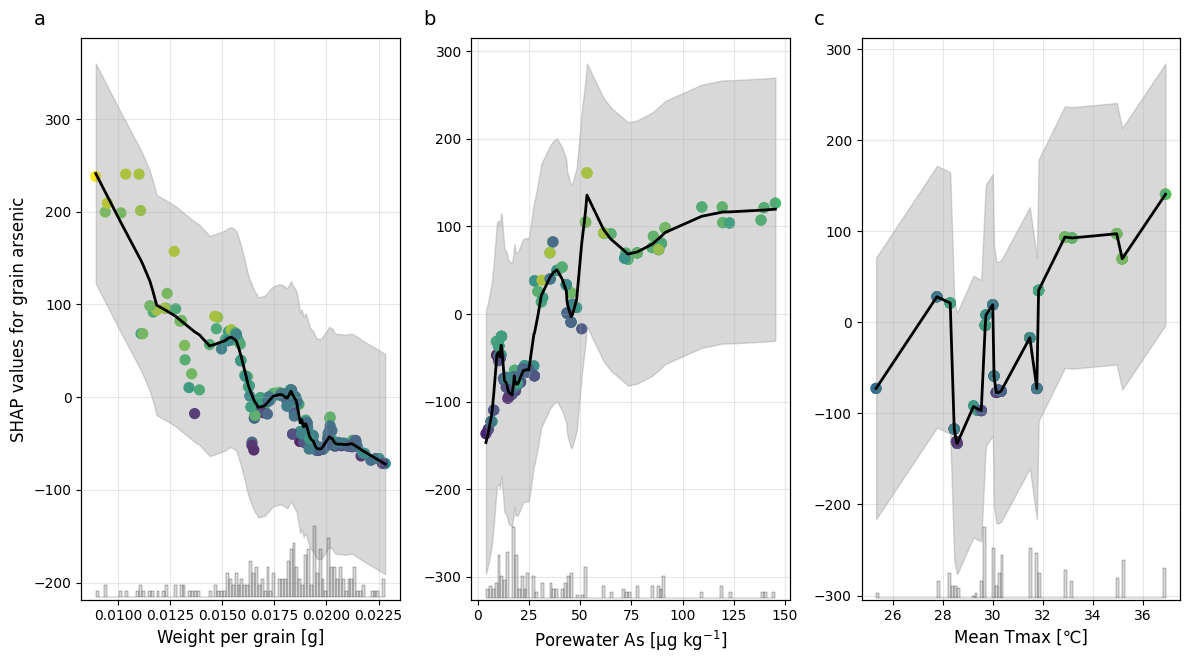

In [2]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import math
from statsmodels.nonparametric.smoothers_lowess import lowess 
import optuna

# Read the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\zhang\seadrive_root\Sha.Zhan\My Libraries\aPhD Papers\热浪\2021 年热浪实验\2021 heat waves rice data.csv')

# Extract the specified columns
new_df = df[['Soil','Mean_VPD','Max_T','Mean_RH','Exetreme_DAYS>31.4', 'Exetreme_DAYS>36','wt per grain', 'tAsp','As 75 ug kg-1']]

# Drop rows with NaN values
new_df_dropped = new_df.dropna()

# Filter rows where "Soil" is not equal to "SY" (replace 'Soil' with the actual column name)
filtered_df = new_df_dropped[new_df_dropped['Soil'] != 'SY']

# Define the X and y variables for further modeling
X = filtered_df[['wt per grain', 'tAsp','Max_T']]
y = filtered_df['As 75 ug kg-1']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth',4,10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 0.95),
        'gamma': trial.suggest_uniform('gamma', 0, 0.5),
        'alpha': trial.suggest_uniform('alpha', 0, 1),
        'lambda': trial.suggest_uniform('lambda', 0, 1)
    }

    xgb_reg = XGBRegressor(**params, random_state=54752075)
    rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=54752075)

    scores = []
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        xgb_reg.fit(X_train_fold, y_train_fold)
        val_pred = xgb_reg.predict(X_val_fold)
        score = mean_squared_error(y_val_fold, val_pred, squared=False)
        scores.append(score)

    return np.mean(scores)

# Perform hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params
print("Best Parameters:")
print(best_params)

# Train the model with the best parameters
best_learner = XGBRegressor(**best_params, random_state=54752075)
best_learner.fit(X_train, y_train)

# Make predictions on the test set
best_prediction = best_learner.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, best_prediction, squared=False)

# Create a DataFrame with prediction and observation values
results = pd.DataFrame({'Observation': y_test, 'Prediction': best_prediction})

# Print the DataFrame and RMSE
#print(results)
print(f"RMSE: {rmse:.4f}")
# Save the DataFrame as a CSV file
results.to_csv('prediction_results.csv', index=False)

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import string
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm
from sklearn.model_selection import KFold


# Compute the SHAP values for the input features,'Max_T':2, 'Mean_RH':2,'Exetreme_DAYS>33':2
shap_values = shap.TreeExplainer(best_learner).shap_values(X)
# Create a DataFrame with the SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Merge the 'Treatment' feature with the SHAP values DataFrame
#merged_df = pd.merge(df[['Treatment']], shap_df, left_index=True, right_index=True)
#print(merged_df)
# Extract 'wt per grain' and 'As 75 ug kg-1' columns into a new DataFrame
selected_columns = ['Soil','wt per grain', 'tAsp','Mean_RH','Max_T','As 75 ug kg-1']
selected_df = df[selected_columns]
# Remove rows containing NaN values in the selected columns
selected_df = selected_df.dropna()
# Filter rows where "Soil" is not equal to "SY" (replace 'Soil' with the actual column name)
selected_dff = selected_df[selected_df['Soil'] != 'SY']
print(selected_dff)
# Define the format labels for each feature
formats = {
    'wt per grain': 'Weight per grain [g]',
    'tAsp': 'Porewater As [$\mathrm{\mu}$g kg$^{-1}$]',
    'Max_T': 'Mean Tmax [℃]',
}
# Create a figure with subplots for each feature
fig, axs = plt.subplots(nrows=1, ncols=len(['tAsp', 'wt per grain','Max_T']), 
                        figsize=(12, 7), constrained_layout=True)
#,'Exetreme_DAYS>33','Mean_VPD','Mean_RH'

def calculate_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

for i, feature in enumerate(['wt per grain', 'tAsp','Max_T']):
    
    if i % len(['wt per grain', 'tAsp','Max_T']) == 0:
        axs[i].set_ylabel('SHAP values for grain arsenic', fontsize=12)
         
    axs[i].grid(True, alpha=0.3)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)
    axs[i].text(-0.15, 1.05, string.ascii_lowercase[i], transform=axs[i].transAxes, fontsize=14, va='top')
    
    
    best_lowess_fit = None
    best_mse = float('inf')  # Initialize with a large value
    # Define the smoothing parameters to try
    smoothing_params = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
    for smoothing_param in smoothing_params:
        mse_scores = []
        for train_idx, val_idx in KFold(n_splits=10, shuffle=True).split(X[feature]):
            X_train, X_val = X[feature].iloc[train_idx], X[feature].iloc[val_idx]
            y_train, y_val = shap_df[feature].iloc[train_idx], shap_df[feature].iloc[val_idx]
            
            # Create scatter plot with Lowess regression line
            #the optimized one is frac=0.5, however, there are many noises, so i used a 
            lowess_fit = lowess(y_train, X_train, frac=smoothing_param)
            
            # Calculate mean squared error for the validation set
            y_pred = np.interp(X_val, lowess_fit[:, 0], lowess_fit[:, 1])
            mse = calculate_mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)
        
        avg_mse = np.mean(mse_scores)
        
        # Store the Lowess fit for the best mean squared error
        if avg_mse < best_mse:
            best_lowess_fit = lowess_fit
            best_mse = avg_mse
            print (best_mse)
    
    # Plot the best Lowess fit for the current feature
    selected_dff['As 75 ug kg-1_log'] = np.log(selected_dff['As 75 ug kg-1'])
    axs[i].plot(best_lowess_fit[:, 0], best_lowess_fit[:, 1], color='black', linestyle='-', alpha=1, linewidth=2, 
                label='Optimized Lowess (Avg MSE {:.2f})'.format(best_mse))
    scatter = axs[i].scatter(X[feature], shap_df[feature],  c=selected_dff['As 75 ug kg-1_log'],cmap='viridis', alpha=1, s=50)
    axs[i].fill_between(best_lowess_fit[:, 0], best_lowess_fit[:, 1] - 1.96 * np.std(shap_df[feature]), 
                        best_lowess_fit[:, 1] + 1.96 * np.std(shap_df[feature]), color='gray', alpha=0.3, label='95% CI')
    axs[i].set_xlabel(formats[feature], fontsize=12)
   # print(smoothing_param)
    
   
    # Create histogram and KDE plot on separate axes with a secondary y-axis
    ax_hist = axs[i].twinx()
    sns.histplot(X[feature], ax=ax_hist, color='gray', alpha=0.3, bins=100, kde=False)
    #sns.kdeplot(X[feature], ax=ax_hist, color='red', alpha=0.5, linewidth=2)
    ax_hist.set_yticks([])
    #ax_hist.set_ylabel('Density', fontsize=16)
    ax_hist.yaxis.tick_right()
    #ax_hist.yaxis.set_label_position("right")
    #ax_hist.spines['right'].set_position(('axes', 1.1))
    ax_hist.set_ylim(-0.5, ax_hist.get_ylim()[1] * 7.5)
    # hide the ticks of the secondary y-axis
    ax_hist.set_yticks([])
    ax_hist.yaxis.label.set_text('')
    

# Add a gradient colorbar for all subplots
#cbar = fig.colorbar(scatter, ax=axs.ravel().tolist())
#cbar.ax.set_ylabel('ln(Grain arsenic [mg kg$^{-1}$])', fontsize=16)

# Set the space between subplots
plt.subplots_adjust(wspace=0.3)
# Set the layout engine explicitly
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('As_wt_per_grain_31.4.tif', dpi=1200, bbox_inches='tight')
plt.show()

In [31]:
# Assuming 'shap_values' is the SHAP values array and 'X' is the DataFrame with selected features

# Create a DataFrame with the SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Combine SHAP values with the selected features
shap_with_features = pd.concat([X.reset_index(drop=True), shap_df], axis=1)

# Save the combined DataFrame to a CSV file
shap_with_features.to_csv('shap_values_with_selected_features.csv', index=False)

print("SHAP values and corresponding features have been saved to 'shap_values_with_selected_features.csv'.")


SHAP values and corresponding features have been saved to 'shap_values_with_selected_features.csv'.


    Soil  wt per grain       tAsp  Mean_RH  Max_T  As 75 ug kg-1
14    XC      0.015191  45.602633    80.61  34.95     733.369955
15    XC      0.013056  45.602633    80.61  34.95     745.383054
19    XC      0.016560  85.134524    80.61  34.95     658.853408
20    XC      0.016082  85.134524    80.61  34.95     658.537199
24    XC      0.014727  73.326067    80.61  34.95     626.369641
..   ...           ...        ...      ...    ...            ...
522  YCH      0.015243  14.159274    81.08  31.48     436.974703
523  YCH      0.016327  14.159274    81.08  31.48     425.365972
524  YCH      0.018347  14.255920    81.08  31.48     392.682594
525  YCH      0.011093  88.307278    81.08  31.48     898.528445
526  YCH      0.015687  14.255920    81.08  31.48     397.671941

[224 rows x 6 columns]
396.45049585651054



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


312.06282100166607



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
invalid value encountered in divide


0.8334239631442427



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
The figure layout has changed to tight


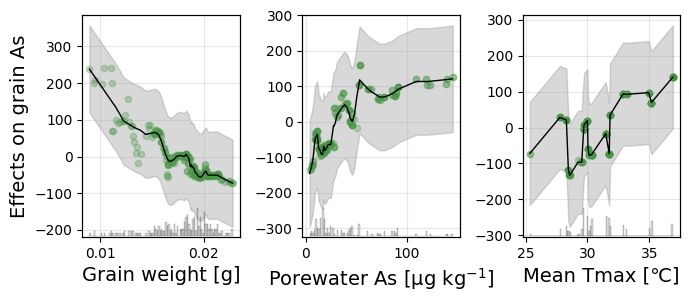

In [34]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import string
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm
from sklearn.model_selection import KFold


# Compute the SHAP values for the input features,'Max_T':2, 'Mean_RH':2,'Exetreme_DAYS>33':2
shap_values = shap.TreeExplainer(best_learner).shap_values(X)
# Create a DataFrame with the SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Merge the 'Treatment' feature with the SHAP values DataFrame
#merged_df = pd.merge(df[['Treatment']], shap_df, left_index=True, right_index=True)
#print(merged_df)
# Extract 'wt per grain' and 'As 75 ug kg-1' columns into a new DataFrame
selected_columns = ['Soil','wt per grain', 'tAsp','Mean_RH','Max_T','As 75 ug kg-1']
selected_df = df[selected_columns]
# Remove rows containing NaN values in the selected columns
selected_df = selected_df.dropna()
# Filter rows where "Soil" is not equal to "SY" (replace 'Soil' with the actual column name)
selected_dff = selected_df[selected_df['Soil'] != 'SY']
print(selected_dff)
# Define the format labels for each feature
formats = {
    'wt per grain': 'Grain weight [g]',
    'tAsp': 'Porewater As [$\mathrm{\mu}$g kg$^{-1}$]',
    'Max_T': 'Mean Tmax [℃]',
}
# Create a figure with subplots for each feature
fig, axs = plt.subplots(nrows=1, ncols=len(['tAsp', 'wt per grain','Max_T']), 
                        figsize=(7, 3.25), constrained_layout=True)
#,'Exetreme_DAYS>33','Mean_VPD','Mean_RH'

def calculate_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

for i, feature in enumerate(['wt per grain', 'tAsp','Max_T']):
    
    if i % len(['wt per grain', 'tAsp','Max_T']) == 0:
        axs[i].set_ylabel('Effects on grain As', fontsize=14)
         
    axs[i].grid(True, alpha=0.3)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)
    #axs[i].text(-0.15, 1.1, string.ascii_lowercase[i], transform=axs[i].transAxes, fontsize=14, va='top')
    
    
    best_lowess_fit = None
    best_mse = float('inf')  # Initialize with a large value
    # Define the smoothing parameters to try
    smoothing_params = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
    for smoothing_param in smoothing_params:
        mse_scores = []
        for train_idx, val_idx in KFold(n_splits=10, shuffle=True).split(X[feature]):
            X_train, X_val = X[feature].iloc[train_idx], X[feature].iloc[val_idx]
            y_train, y_val = shap_df[feature].iloc[train_idx], shap_df[feature].iloc[val_idx]
            
            # Create scatter plot with Lowess regression line
            #the optimized one is frac=0.5, however, there are many noises, so i used a 
            lowess_fit = lowess(y_train, X_train, frac=smoothing_param)
            
            # Calculate mean squared error for the validation set
            y_pred = np.interp(X_val, lowess_fit[:, 0], lowess_fit[:, 1])
            mse = calculate_mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)
        
        avg_mse = np.mean(mse_scores)
        
        # Store the Lowess fit for the best mean squared error
        if avg_mse < best_mse:
            best_lowess_fit = lowess_fit
            best_mse = avg_mse
            print (best_mse)
    
    # Plot the best Lowess fit for the current feature
    selected_dff['As 75 ug kg-1_log'] = np.log(selected_dff['As 75 ug kg-1'])
    axs[i].plot(best_lowess_fit[:, 0], best_lowess_fit[:, 1], color='black', linestyle='-', alpha=1, linewidth=1, 
                label='Optimized Lowess (Avg MSE {:.2f})'.format(best_mse))
    scatter = axs[i].scatter(X[feature], shap_df[feature],color='tab:green', alpha=0.3, s=20)
    axs[i].fill_between(best_lowess_fit[:, 0], best_lowess_fit[:, 1] - 1.96 * np.std(shap_df[feature]), 
                        best_lowess_fit[:, 1] + 1.96 * np.std(shap_df[feature]), color='gray', alpha=0.3, label='95% CI')
    axs[i].set_xlabel(formats[feature], fontsize=14)
   # print(smoothing_param)
    
   
    # Create histogram and KDE plot on separate axes with a secondary y-axis
    ax_hist = axs[i].twinx()
    sns.histplot(X[feature], ax=ax_hist, color='gray', alpha=0.3, bins=100, kde=False)
    #sns.kdeplot(X[feature], ax=ax_hist, color='red', alpha=0.5, linewidth=2)
    ax_hist.set_yticks([])
    #ax_hist.set_ylabel('Density', fontsize=16)
    ax_hist.yaxis.tick_right()
    #ax_hist.yaxis.set_label_position("right")
    #ax_hist.spines['right'].set_position(('axes', 1.1))
    ax_hist.set_ylim(-0.5, ax_hist.get_ylim()[1] * 7.5)
    # hide the ticks of the secondary y-axis
    ax_hist.set_yticks([])
    ax_hist.yaxis.label.set_text('')
    

# Add a gradient colorbar for all subplots
#cbar = fig.colorbar(scatter, ax=axs.ravel().tolist())
#cbar.ax.set_ylabel('ln(Grain arsenic [mg kg$^{-1}$])', fontsize=16)

# Set the space between subplots
plt.subplots_adjust(wspace=0.3)
# Set the layout engine explicitly
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig('As_wt_per_grain_31.4.tif', dpi=1200, bbox_inches='tight')
plt.show()

In [29]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import string
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import KFold

# Assuming 'best_learner' is your trained model and 'X' is your feature data
# Compute the SHAP values for the input features
shap_values = shap.TreeExplainer(best_learner).shap_values(X)

# Create a DataFrame with the SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Select specific columns from your main data
selected_columns = ['Soil', 'wt per grain', 'tAsp', 'Mean_RH', 'Max_T', 'As 75 ug kg-1']
selected_df = df[selected_columns]

# Remove rows containing NaN values in the selected columns
selected_df = selected_df.dropna()

# Filter rows where "Soil" is not equal to "SY"
selected_dff = selected_df[selected_df['Soil'] != 'SY']

# Merge SHAP values with the selected data
# Assuming SHAP values correspond to the features selected, so we match the index
merged_df = selected_dff.merge(shap_df, left_index=True, right_index=True, suffixes=('_data', '_shap'))

# Save the merged data to a new CSV file
merged_df.to_csv(r'C:\Users\zhang\Documents\A_Varieties from 1987 to 2017\selected_data_with_shap.csv', index=False)


In [8]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import math
from statsmodels.nonparametric.smoothers_lowess import lowess 
import optuna
import pandas as pd
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
import pandas as pd
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import math
import xgboost
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Read the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\zhang\seadrive_root\Sha.Zhan\My Libraries\aPhD Papers\热浪\2021 年热浪实验\2021 heat waves rice data.csv')

# Extract the specified columns
new_df = df[['Soil','Mean_VPD','Max_T','Mean_RH','Exetreme_DAYS>31.4', 'Exetreme_DAYS>36','wt per grain', 'tAsp','As 75 ug kg-1']]

# Drop rows with NaN values
new_df_dropped = new_df.dropna()

# Filter rows where "Soil" is not equal to "SY" (replace 'Soil' with the actual column name)
filtered_df = new_df_dropped[new_df_dropped['Soil'] != 'SY']

# Define the X and y variables for further modeling
X = filtered_df[['wt per grain', 'tAsp','Max_T']]
y = filtered_df['As 75 ug kg-1']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Define best parameters
best_params = {'learning_rate': 0.011193523147975181, 'n_estimators': 549, 'max_depth': 4, 'subsample': 0.5806667863482236, 'colsample_bytree': 0.6179456256268018, 
               'gamma': 0.4936862008151065, 'alpha': 0.007078765575369378, 'lambda': 0.8830391620611333}

# Create an XGBoost regressor with best parameters
best_learner = XGBRegressor(**best_params, random_state=54752075)

# Fit the model to the training data
best_learner.fit(X_train, y_train)

# Make predictions on the test set
best_prediction = best_learner.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, best_prediction))

# Print R-squared, Accuracy, MAE, and RMSE values
print('R2 Value_train:', r2_score(y, best_learner.predict(X)))
print('R2 Value_test:', r2_score(y_test, best_learner.predict(X_test)))
accuracy = 100 - (np.mean(np.abs((y_test - best_prediction) / y_test)) * 100)
print('Accuracy:', accuracy)
print('MAE_train:', mean_absolute_error(y_train, best_learner.predict(X_train)))
print('MAE_test:', mean_absolute_error(y_test, best_learner.predict(X_test)))
print('RMSE_train:', np.sqrt(mean_squared_error(y_train, best_learner.predict(X_train))))
print('RMSE_test:', rmse)

# Create a DataFrame with prediction and observation values
results = pd.DataFrame({'Observation': y_test, 'Prediction': best_prediction})

# Print the DataFrame and RMSE
print(results)
print(f"RMSE: {rmse:.4f}")

# Print best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Save the DataFrame as a CSV file
results.to_csv('optimized_prediction_results_grainarsenic.csv', index=False)

R2 Value_train: 0.8617807559580227
R2 Value_test: 0.6960752988059393
Accuracy: 79.35801408073705
MAE_train: 52.65487667095301
MAE_test: 80.12612632113282
RMSE_train: 65.83681699304232
RMSE_test: 105.26468249184143
     Observation  Prediction
211   640.811293  451.887329
468   227.679708  267.127594
201   473.255440  531.472717
524   392.682594  405.866577
522   436.974703  462.207550
448   481.097108  346.878174
482   329.702966  460.737610
101   645.825909  640.693115
503   939.913271  821.358154
446   691.121495  647.380066
430   465.563163  474.480347
262   780.780365  539.067993
480   348.782929  343.938171
433   461.591895  400.863159
523   425.365972  402.677582
439   227.420143  285.885406
212   752.795933  453.515289
66    656.108153  610.608948
352   487.412156  384.764587
207   524.087759  322.291443
399   330.501970  365.766937
335   156.151277  257.585327
391   211.906112  300.849457
314   182.880383  275.151642
443   467.787266  478.281708
412   444.588490  284.631500
133

In [9]:
import numpy as np

# Calculate the squared SHAP values for each feature
shap_values_squared = shap_values ** 2

# Sum up the squared SHAP values for each feature
total_explained_variance = np.sum(shap_values_squared, axis=0)

# Calculate the proportion of explained variance for each feature
proportion_explained_variance = total_explained_variance / np.sum(total_explained_variance)*86.17807559580227

# List of feature names
feature_names = ['wt per grain', 'tAsp','Max_T']  # Add your feature names here

# Number of bootstrap samples
num_bootstrap_samples = 1000  # You can adjust this value based on your needs

# List to store bootstrap samples of proportions of explained variance
bootstrap_samples = []

# Perform bootstrapping
for _ in range(num_bootstrap_samples):
    # Randomly sample indices with replacement
    indices = np.random.choice(range(shap_values_squared.shape[0]), size=shap_values_squared.shape[0], replace=True)
    
    # Calculate the total explained variance for the bootstrap sample
    bootstrap_total_explained_variance = np.sum(shap_values_squared[indices], axis=0)
    
    # Calculate the proportion of explained variance for the bootstrap sample
    bootstrap_proportion_explained_variance = bootstrap_total_explained_variance / np.sum(bootstrap_total_explained_variance)*86.17807559580227
    # Append the bootstrap sample to the list
    bootstrap_samples.append(bootstrap_proportion_explained_variance)

# Convert the list of bootstrap samples to a NumPy array
bootstrap_samples = np.array(bootstrap_samples)

# Calculate the lower and upper percentiles for the confidence interval
confidence_interval_lower = np.percentile(bootstrap_samples, 2.5, axis=0)
confidence_interval_median = np.percentile(bootstrap_samples, 50, axis=0)
confidence_interval_upper = np.percentile(bootstrap_samples, 97.5, axis=0)

# Print out the confidence intervals for each feature
   
for feature, lower,median, upper, proportion in zip(feature_names, confidence_interval_lower,confidence_interval_median,
                                                    confidence_interval_upper,proportion_explained_variance):
    print(f"{feature},Mean:{proportion:.1f} [{lower:.1f},{median:.1f}, {upper:.1f}]")


wt per grain,Mean:21.2 [16.5,21.2, 25.6]
tAsp,Mean:34.0 [30.5,34.0, 37.6]
Max_T,Mean:31.0 [28.3,31.1, 34.1]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM
from scipy.signal import find_peaks

font_size = 14
#plt.style.use('seaborn')
# plt.rc('font', size=font_size)        # default text size (won't work)
plt.rc('axes', titlesize=font_size)   # title
plt.rc('axes', labelsize=font_size)   # x and y labels
plt.rc('xtick', labelsize=font_size)  # x tick labels
plt.rc('ytick', labelsize=font_size)  # y tick labels
plt.rc('legend', fontsize=font_size)  # legend
plt.rc('lines', markersize=3)    

# Create a figure with subplots for each feature
fig, axs = plt.subplots(nrows=1, ncols=len(['TS_2', 'NEE', 'VPD', 'R_REDOX']), figsize=(15, 6), constrained_layout=True)
# Define the format for each feature
formats = {'TS_2': 'Soil T [℃]', 'NEE': 'NEE [$\mu$mol m$^{-2}$ s$^{-1}$]', 
           'VPD': 'VPD [kPa]', 'R_REDOX': 'Redox index'}
# Define a color mapping dictionary based on unique 'SITE' values
site_colors = {
    'CHN_Njjs':'tab:blue',
    'IT_Cas': 'tab:red',
    'US_Twt': 'tab:orange',
    'PH_RiF': 'tab:purple',
    'KR_CRK': 'tab:green',
    'JP_Mse': 'black',
    'US_HRA':'grey',
    'US_HRC':'grey',
    'CHN_Ycjs':'pink',
    'KY_Kryg':'red'
    # Add more 'SITE' names and corresponding colors as needed
}
# Define ranges for each feature
ranges = {'TS_2': [12, 25], 'NEE': [-30, 3], 'VPD': [0.0, 2.5], 'R_REDOX': [-0.4, 0.3]}

# Information about features, proportions, and confidence intervals
for i, feature in enumerate(['TS_2', 'NEE', 'VPD', 'R_REDOX']):
    axs[i].grid(True, alpha=0.3)
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    axs[i].text(-0.15, 1.05, f'b{i+1}', transform=axs[i].transAxes, fontsize=16, va='top',fontweight='bold')

    # Fit a GAM model with a higher smoothing parameter (e.g., lam=0.6)
    gam = LinearGAM(lam=0.6).fit(X[feature], shap_df[feature])

    # Plot the GAM fit
    X_values = np.linspace(min(X[feature]), max(X[feature]), 100)
    gam_pred = gam.predict(X_values)
    axs[i].plot(X_values, gam_pred, color='black', linestyle='-', alpha=1, linewidth=3, label='GAM fit')

    # Compute confidence intervals
    confidence_intervals = gam.prediction_intervals(X_values, width=.95)

    # Plot confidence intervals
    axs[i].fill_between(X_values, confidence_intervals[:, 0], confidence_intervals[:, 1], 
                        color='lightgray', alpha=0.5, label='95% CI')

    # Compute the derivative of the GAM predictions
    derivative = np.gradient(gam_pred, X_values)
    
    # Find the points where the derivative changes sign within the specified ranges
    sign_changes = np.where(np.logical_and(derivative[:-1] * derivative[1:] < 0, 
                                           np.logical_and(X_values[:-1] >= ranges[feature][0], 
                                                          X_values[:-1] <= ranges[feature][1])))[0]
    tipping_points = X_values[sign_changes]
    
    offsets = {0: 1, 1: 0.1, 2: -1.5,3:-1.0}  # Adjust offset values for each subplot as needed
    
    if tipping_points.size > 0:
        # Plot lines from tipping points to top of subplot
        for tp_x, tp_y in zip(tipping_points, gam.predict(tipping_points)):
            max_y_limit = axs[i].get_ylim()[1]  # Get the maximum y-limit value
            offset = offsets.get(i, 0.2) * (max_y_limit - axs[i].get_ylim()[0])  # Adjust this factor as needed
            text_y = max_y_limit + offset
            axs[i].text(tp_x, text_y, f'{tp_x:.1f}', fontsize=14, color='blue', verticalalignment='bottom', 
                        horizontalalignment='center')
            axs[i].plot([tp_x, tp_x], [axs[i].get_ylim()[0], max_y_limit], color='blue', linestyle='--', linewidth=1)

    # Plot the scatter plot of the data
    axs[i].scatter(X[feature], shap_df[feature], c=[site_colors[x] for x in df['SITE']], alpha=0.1, s=1)

    axs[i].set_xlabel(formats[feature], fontsize=16)

    # Keep only the y-axis label for the first subplot
    if i > 0:
        axs[i].set_ylabel('')
    else:
        axs[i].set_ylabel('SHAP value\n[Effect Relative to Avg Prediction]', fontsize=16)

# Add a legend for the SITE names and colors to the first subplot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              label=t, markerfacecolor=c, markersize=10) for t, c in site_colors.items()]
axs[3].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, 
              title="Site", title_fontsize=16)

# Set the space between subplots
plt.subplots_adjust(wspace=0.15)

# Save or show the plot
plt.tight_layout()
plt.savefig('fCH4_mode2_gam_with_GAM_1and_tipping_points.tif', dpi=1200, format='tiff')
plt.show()


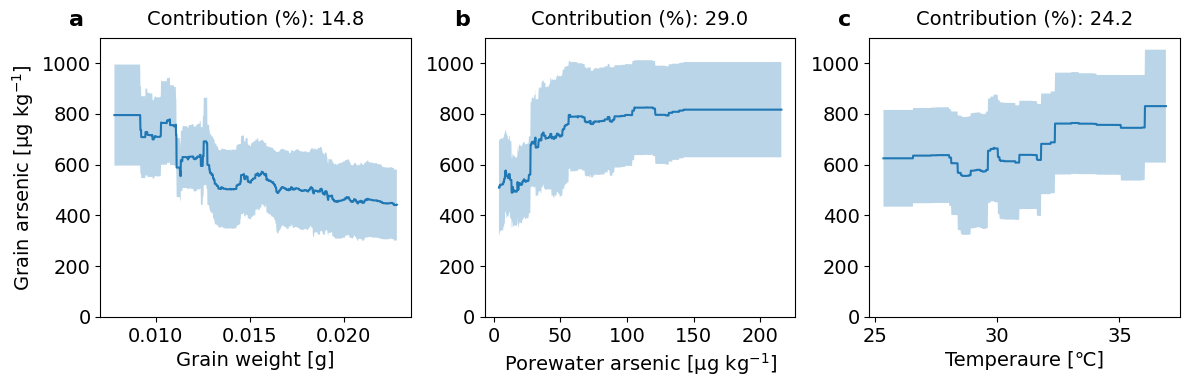

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

font_size = 14
#plt.style.use('seaborn')
# plt.rc('font', size=font_size)        # default text size (won't work)
plt.rc('axes', titlesize=font_size)   # title
plt.rc('axes', labelsize=font_size)   # x and y labels
plt.rc('xtick', labelsize=font_size)  # x tick labels
plt.rc('ytick', labelsize=font_size)  # y tick labels
plt.rc('legend', fontsize=font_size)  # legend
plt.rc('lines', markersize=10)    
plt.rc('lines', linewidth =1.5) 
# Define the features of interest
#features_of_interest = ['TS_2', 'NEE', 'VPD', 'R_REDOX']
features_of_interest = ['wt per grain', 'tAsp','Max_T']

# Define the format for each feature
formats = {    "wt per grain": "Grain weight [g]",
           "tAsp":"Porewater arsenic [$\mathrm{\mu}$g kg$^{-1}$]",
    "Max_T": "Temperaure [℃]"
}

# Define means and uncertainties for each feature
means = [14.8, 29.0, 24.2]
uncertainties = [(10.6, 14.5, 18.6), (25.5, 29.1, 33.0), (21.4, 24.2, 27.1)]

# 'wt per grain': 'Weight per grain [g]',
# Select a subset of data with the features of interest and other relevant features
subset_data = df[["As 75 ug kg-1"] + features_of_interest]

# Fix the values of other features (e.g., 'Feature_Y' and 'Feature_Z')
fixed_feature_values = {
     'wt per grain': subset_data['wt per grain'].median(),
    'tAsp': subset_data['tAsp'].median(),
    'Max_T':subset_data['Max_T'].median()
}

# Create subplots for each feature
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()

# Inside the loop
for i, feature_of_interest in enumerate(features_of_interest):
    # Calculate predictions for the subset data while varying the current feature
    predictions = []
    uncertainty = []
    feature_values_range = np.linspace(subset_data[feature_of_interest].min(), subset_data[feature_of_interest].max(), 1000)
    
    for feature_value in feature_values_range:
        # Create a copy of the original subset_data to avoid modifying it in place
        subset_data_copy = subset_data.copy()
        # Set the current feature values in the copy
        subset_data_copy.loc[:, feature_of_interest] = feature_value
        # Make predictions using your model (e.g., XGBoost) on the copy
        subset_predictions = best_learner.predict(subset_data_copy[features_of_interest])
        # Append the predictions
        predictions.append(subset_predictions.mean())
        # Calculate uncertainty (e.g., standard deviation) on the copy
        uncertainty.append(subset_predictions.std())
    
    # Create a partial relationship plot with uncertainty for the current feature
    axs[i].plot(feature_values_range, predictions, linestyle='-', label='')
    axs[i].fill_between(feature_values_range, np.array(predictions) - np.array(uncertainty), 
                        np.array(predictions) + np.array(uncertainty), alpha=0.3, label='')
    axs[i].set_xlabel(formats[feature_of_interest], fontsize=14)  # Use the formatted label
    axs[i].set_ylabel('Grain arenic [$\mathrm{\mu}$g kg$^{-1}$]', fontsize=12)
    #axs[i].set_title(f'Partial Relationship Plot for {formats[feature_of_interest]} with Uncertainty', fontsize=12)  # Use the formatted title
    # Add a label to the top-left corner of each subplot
    #axs[i].legend()
    axs[i].grid(False)
    
    if i == 0:
        axs[i].set_ylabel('Grain arsenic [$\mathrm{\mu}$g kg$^{-1}$]', fontsize=14)
        axs[i].xaxis.set_major_locator(MaxNLocator(nbins=4))
        #axs[i].yaxis.set_major_locator(MaxNLocator(nbins=4))
    else:
        axs[i].set_ylabel('')
        
    axs[i].set_ylim(0,1100)
    axs[i].text(-0.1, 1.1, chr(97 + i), transform=axs[i].transAxes, 
                fontsize=16, fontweight='bold', va='top')
    axs[i].grid(False)
    # Annotate with mean and uncertainties
    axs[i].text(0.15, 1.1, f"Contribution (%): {means[i]}",
                transform=axs[i].transAxes, fontsize=14, verticalalignment='top')    
        # Set the space between subplots
plt.subplots_adjust(wspace=0.1)
# Adjust subplot layout
plt.tight_layout()

#plt.tight_layout()
plt.savefig('Grain arsenic prediction.tif', dpi=1200, bbox_inches='tight')
plt.show()


Fitting 100 folds for each of 50 candidates, totalling 5000 fits
Best Parameters:
subsample: 0.6
n_estimators: 500
max_depth: 5
learning_rate: 0.01
lambda: 0
gamma: 0.1
colsample_bytree: 0.9
alpha: 0.2
R2 Value_train: 0.9687750638682715
R2 Value_test: 0.6987825567652615
Accuracy: 78.0324248751599
MAE_train: 30.08830438386981
MAE_test: 82.32579513499999
RMSE_train: 36.08897455838184
RMSE_test: 104.7948027585217
RMSE: 104.7948
    Soil  wt per grain       tAsp  Exetreme_DAYS>36  Mean_VPD  As 75 ug kg-1
14    XC      0.015191  45.602633                70      0.89     733.369955
15    XC      0.013056  45.602633                70      0.89     745.383054
19    XC      0.016560  85.134524                70      0.89     658.853408
20    XC      0.016082  85.134524                70      0.89     658.537199
24    XC      0.014727  73.326067                70      0.89     626.369641
..   ...           ...        ...               ...       ...            ...
522  YCH      0.015243  14.15927


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


627.4920853591395



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in divide


217.18691666223305



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in divide


259.4801080469122



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.


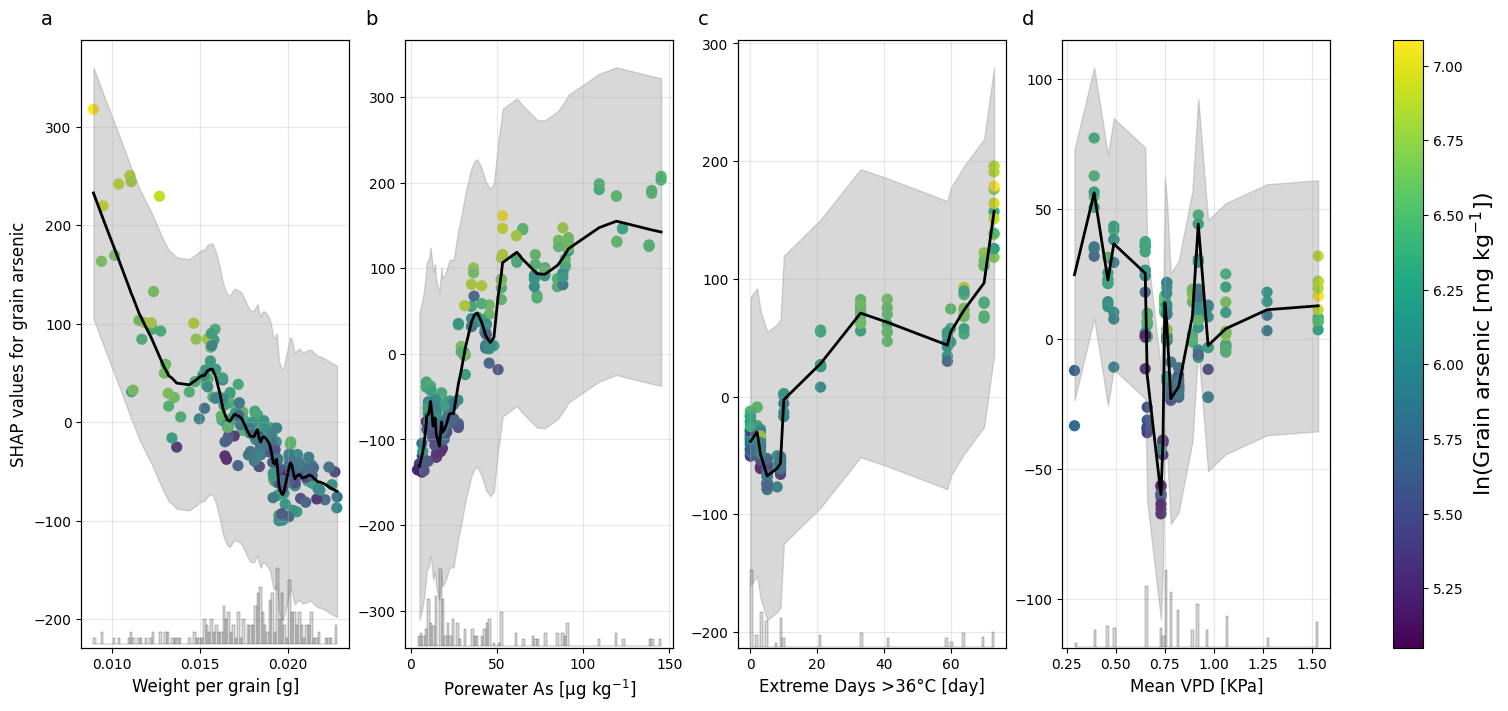

In [8]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import math
from statsmodels.nonparametric.smoothers_lowess import lowess 

# Read the CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\zhang\seadrive_root\Sha.Zhan\My Libraries\aPhD Papers\热浪\2021 年热浪实验\2021 heat waves rice data.csv')

# Extract the specified columns
new_df = df[['Soil','Mean_VPD','Max_T','Mean_RH','Exetreme_DAYS>31.4', 'Exetreme_DAYS>36','wt per grain', 'tAsp','As 75 ug kg-1']]

# Drop rows with NaN values
new_df_dropped = new_df.dropna()

# Filter rows where "Soil" is not equal to "SY" (replace 'Soil' with the actual column name)
filtered_df = new_df_dropped[new_df_dropped['Soil'] != 'SY']

# Define the X and y variables for further modeling
X = filtered_df[['wt per grain', 'tAsp', 'Exetreme_DAYS>36', 'Mean_VPD']]
y = filtered_df['As 75 ug kg-1']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Hyperparameter optimization using RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2],
    'lambda': [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=54752075),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=RepeatedKFold(n_splits=10, n_repeats=10, random_state=54752075),
    verbose=2,
    random_state=54752075,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Define and train the XGBoost model with the best parameters
best_learner = XGBRegressor(random_state=54752075, **best_params)
best_learner.fit(X_train, y_train)

# Make predictions on the test set
best_prediction = best_learner.predict(X_test)
# Calculate RMSE
rmse = mean_squared_error(y_test, best_prediction, squared=False)

# Print R-squared, Accuracy, MAE, and RMSE values
print('R2 Value_train:', metrics.r2_score(y_train, best_learner.predict(X_train)))
print('R2 Value_test:', metrics.r2_score(y_test, best_learner.predict(X_test)))
accuracy = 100 - (np.mean(np.abs((y_test - best_prediction) / y_test)) * 100)
print('Accuracy:', accuracy)
print('MAE_train:', metrics.mean_absolute_error(y_train, best_learner.predict(X_train)))
print('MAE_test:', metrics.mean_absolute_error(y_test, best_learner.predict(X_test)))
MSE_train = np.square(np.subtract(y_train, best_learner.predict(X_train))).mean()
MSE_test = np.square(np.subtract(y_test, best_learner.predict(X_test))).mean()
RMSE_train = math.sqrt(MSE_train)
RMSE_test = math.sqrt(MSE_test)
print('RMSE_train:', RMSE_train)
print('RMSE_test:', RMSE_test)

# Create a DataFrame with prediction and observation values
results = pd.DataFrame({'Observation': y_test, 'Prediction': best_prediction})

# Print the DataFrame and RMSE
#print(results)
print(f"RMSE: {rmse:.4f}")
# Save the DataFrame as a CSV file
results.to_csv('prediction_results.csv', index=False)

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import string
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm
from sklearn.model_selection import KFold


# Compute the SHAP values for the input features,'Max_T':2, 'Mean_RH':2,'Exetreme_DAYS>33':2
shap_values = shap.TreeExplainer(best_learner).shap_values(X)
# Create a DataFrame with the SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Merge the 'Treatment' feature with the SHAP values DataFrame
#merged_df = pd.merge(df[['Treatment']], shap_df, left_index=True, right_index=True)
#print(merged_df)
# Extract 'wt per grain' and 'As 75 ug kg-1' columns into a new DataFrame
selected_columns = ['Soil','wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_VPD','As 75 ug kg-1']
selected_df = df[selected_columns]
# Remove rows containing NaN values in the selected columns
selected_df = selected_df.dropna()
# Filter rows where "Soil" is not equal to "SY" (replace 'Soil' with the actual column name)
selected_dff = selected_df[selected_df['Soil'] != 'SY']
print(selected_dff)
# Define the format labels for each feature
formats = {
    'wt per grain': 'Weight per grain [g]',
    'tAsp': 'Porewater As [$\mathrm{\mu}$g kg$^{-1}$]',
    'Exetreme_DAYS>36': 'Extreme Days >36°C [day]',
    'Mean_VPD': 'Mean VPD [KPa]',
}
# Create a figure with subplots for each feature
fig, axs = plt.subplots(nrows=1, ncols=len(['tAsp', 'wt per grain','Exetreme_DAYS>36','Mean_VPD']), 
                        figsize=(15, 7), constrained_layout=True)
#,'Exetreme_DAYS>33','Mean_VPD','Mean_RH'

def calculate_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

for i, feature in enumerate(['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_VPD']):
    
    if i % len(['wt per grain', 'tAsp','Exetreme_DAYS>36','Mean_VPD']) == 0:
        axs[i].set_ylabel('SHAP values for grain arsenic', fontsize=12)
         
    axs[i].grid(True, alpha=0.3)
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)
    axs[i].text(-0.15, 1.05, string.ascii_lowercase[i], transform=axs[i].transAxes, fontsize=14, va='top')
    
    
    best_lowess_fit = None
    best_mse = float('inf')  # Initialize with a large value
    # Define the smoothing parameters to try
    smoothing_params = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
    for smoothing_param in smoothing_params:
        mse_scores = []
        for train_idx, val_idx in KFold(n_splits=10, shuffle=True).split(X[feature]):
            X_train, X_val = X[feature].iloc[train_idx], X[feature].iloc[val_idx]
            y_train, y_val = shap_df[feature].iloc[train_idx], shap_df[feature].iloc[val_idx]
            
            # Create scatter plot with Lowess regression line
            #the optimized one is frac=0.5, however, there are many noises, so i used a 
            lowess_fit = lowess(y_train, X_train, frac=smoothing_param)
            
            # Calculate mean squared error for the validation set
            y_pred = np.interp(X_val, lowess_fit[:, 0], lowess_fit[:, 1])
            mse = calculate_mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)
        
        avg_mse = np.mean(mse_scores)
        
        # Store the Lowess fit for the best mean squared error
        if avg_mse < best_mse:
            best_lowess_fit = lowess_fit
            best_mse = avg_mse
            print (best_mse)
    
    # Plot the best Lowess fit for the current feature
    selected_dff['As 75 ug kg-1_log'] = np.log(selected_dff['As 75 ug kg-1'])
    axs[i].plot(best_lowess_fit[:, 0], best_lowess_fit[:, 1], color='black', linestyle='-', alpha=1, linewidth=2, 
                label='Optimized Lowess (Avg MSE {:.2f})'.format(best_mse))
    scatter = axs[i].scatter(X[feature], shap_df[feature],  c=selected_dff['As 75 ug kg-1_log'],cmap='viridis', alpha=1, s=50)
    axs[i].fill_between(best_lowess_fit[:, 0], best_lowess_fit[:, 1] - 1.96 * np.std(shap_df[feature]), 
                        best_lowess_fit[:, 1] + 1.96 * np.std(shap_df[feature]), color='gray', alpha=0.3, label='95% CI')
    axs[i].set_xlabel(formats[feature], fontsize=12)
   # print(smoothing_param)
    
   
    # Create histogram and KDE plot on separate axes with a secondary y-axis
    ax_hist = axs[i].twinx()
    sns.histplot(X[feature], ax=ax_hist, color='gray', alpha=0.3, bins=100, kde=False)
    #sns.kdeplot(X[feature], ax=ax_hist, color='red', alpha=0.5, linewidth=2)
    ax_hist.set_yticks([])
    #ax_hist.set_ylabel('Density', fontsize=16)
    ax_hist.yaxis.tick_right()
    #ax_hist.yaxis.set_label_position("right")
    #ax_hist.spines['right'].set_position(('axes', 1.1))
    ax_hist.set_ylim(-0.5, ax_hist.get_ylim()[1] * 7.5)
    # hide the ticks of the secondary y-axis
    ax_hist.set_yticks([])
    ax_hist.yaxis.label.set_text('')
    

# Add a gradient colorbar for all subplots
cbar = fig.colorbar(scatter, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('ln(Grain arsenic [mg kg$^{-1}$])', fontsize=16)

# Set the space between subplots
plt.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.savefig('As_wt_per_grain_31.4.tif', dpi=1200, bbox_inches='tight')
plt.show()

In [6]:
import numpy as np

# Calculate the squared SHAP values for each feature
shap_values_squared = shap_values ** 2

# Sum up the squared SHAP values for each feature
total_explained_variance = np.sum(shap_values_squared, axis=0)

# Calculate the proportion of explained variance for each feature
proportion_explained_variance = total_explained_variance / np.sum(total_explained_variance)*79.69

# List of feature names
feature_names = ['wt per grain','tAsp','Exetreme_DAYS>36','Mean_VPD']  # Add your feature names here

# Number of bootstrap samples
num_bootstrap_samples = 1000  # You can adjust this value based on your needs

# List to store bootstrap samples of proportions of explained variance
bootstrap_samples = []

# Perform bootstrapping
for _ in range(num_bootstrap_samples):
    # Randomly sample indices with replacement
    indices = np.random.choice(range(shap_values_squared.shape[0]), size=shap_values_squared.shape[0], replace=True)
    
    # Calculate the total explained variance for the bootstrap sample
    bootstrap_total_explained_variance = np.sum(shap_values_squared[indices], axis=0)
    
    # Calculate the proportion of explained variance for the bootstrap sample
    bootstrap_proportion_explained_variance = bootstrap_total_explained_variance / np.sum(bootstrap_total_explained_variance)*81.8
    
    # Append the bootstrap sample to the list
    bootstrap_samples.append(bootstrap_proportion_explained_variance)

# Convert the list of bootstrap samples to a NumPy array
bootstrap_samples = np.array(bootstrap_samples)

# Calculate the lower and upper percentiles for the confidence interval
confidence_interval_lower = np.percentile(bootstrap_samples, 2.5, axis=0)
confidence_interval_median = np.percentile(bootstrap_samples, 50, axis=0)
confidence_interval_upper = np.percentile(bootstrap_samples, 97.5, axis=0)

# Print out the confidence intervals for each feature
   
for feature, lower,median, upper, proportion in zip(feature_names, confidence_interval_lower,confidence_interval_median,
                                                    confidence_interval_upper,proportion_explained_variance):
    print(f"{feature},Mean:{proportion:.1f} [{lower:.1f},{median:.1f}, {upper:.1f}]")


wt per grain,Mean:17.1 [12.9,17.3, 21.9]
tAsp,Mean:27.6 [25.2,28.4, 31.8]
Exetreme_DAYS>36,Mean:5.5 [4.8,5.7, 6.7]
Mean_VPD,Mean:29.4 [27.3,30.3, 33.6]


ValueError: feature_names mismatch: ['wt per grain', 'tAsp', 'Mean_RH', 'Max_T'] ['wt per grain', 'tAsp', 'Exetreme_DAYS>36', 'Mean_VPD']
expected Mean_RH, Max_T in input data
training data did not have the following fields: Exetreme_DAYS>36, Mean_VPD

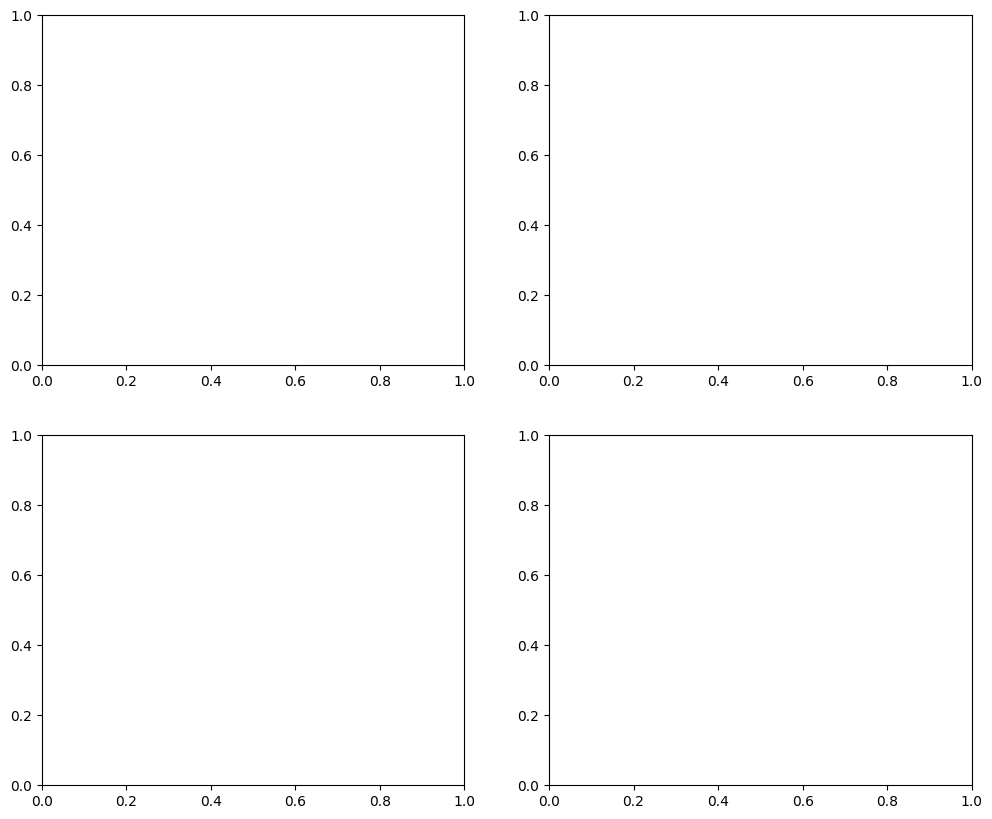

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define the features of interest
#features_of_interest = ['TS_2', 'NEE', 'VPD', 'R_REDOX']
features_of_interest = ['wt per grain', 'tAsp', 'Exetreme_DAYS>36', 'Mean_VPD']

# Define the format for each feature
formats = {'tAsp': 'Soil porewater arsenic [$\mu$g L$^{-1}$]', 'wt per grain': 'Grain weight [g grain$^{-1}$]', 
           'Exetreme_DAYS>36': 'Exetreme_DAYS>36 [day]', 'Mean_VPD': 'VPD [Kpa]'}

# Select a subset of data with the features of interest and other relevant features
subset_data = df[['As 75 ug kg-1'] + features_of_interest]

# Fix the values of other features (e.g., 'Feature_Y' and 'Feature_Z')
fixed_feature_values = {
    'tAsp': subset_data['tAsp'].median(),
    'wt per grain': subset_data['wt per grain'].median(),
    'Exetreme_DAYS>36': subset_data['Exetreme_DAYS>36'].median(),
    'Mean_VPD': subset_data['Mean_VPD'].median()
}

# Create subplots for each feature
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

# Inside the loop
for i, feature_of_interest in enumerate(features_of_interest):
    # Calculate predictions for the subset data while varying the current feature
    predictions = []
    uncertainty = []
    feature_values_range = np.linspace(subset_data[feature_of_interest].min(), subset_data[feature_of_interest].max(), 1000)
    
    for feature_value in feature_values_range:
        # Create a copy of the original subset_data to avoid modifying it in place
        subset_data_copy = subset_data.copy()
        # Set the current feature values in the copy
        subset_data_copy.loc[:, feature_of_interest] = feature_value
        # Make predictions using your model (e.g., XGBoost) on the copy
        subset_predictions = best_learner.predict(subset_data_copy[features_of_interest])
        # Append the predictions
        predictions.append(subset_predictions.mean())
        # Calculate uncertainty (e.g., standard deviation) on the copy
        uncertainty.append(subset_predictions.std())
    
    # Create a partial relationship plot with uncertainty for the current feature
    axs[i].plot(feature_values_range, predictions, linestyle='-', label='')
    axs[i].fill_between(feature_values_range, np.array(predictions) - np.array(uncertainty), 
                        np.array(predictions) + np.array(uncertainty), alpha=0.3, label='')
    axs[i].set_xlabel(formats[feature_of_interest], fontsize=14)  # Use the formatted label
    axs[i].set_ylabel('Total gran arsenic [$\mu$g kg$^{-1}$]', fontsize=12)
    #axs[i].set_title(f'Partial Relationship Plot for {formats[feature_of_interest]} with Uncertainty', fontsize=12)  # Use the formatted title
    # Add a label to the top-left corner of each subplot
    axs[i].text(-0.05, 1.05, chr(97+i), transform=axs[i].transAxes, fontsize=14, fontweight='bold', va='top')
    #axs[i].legend()
    axs[i].grid(True)
# Adjust subplot layout
plt.tight_layout()

# Set the space between subplots
plt.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.savefig('As_wt_per_grain_prediction.tif', dpi=1200, bbox_inches='tight')
plt.show()


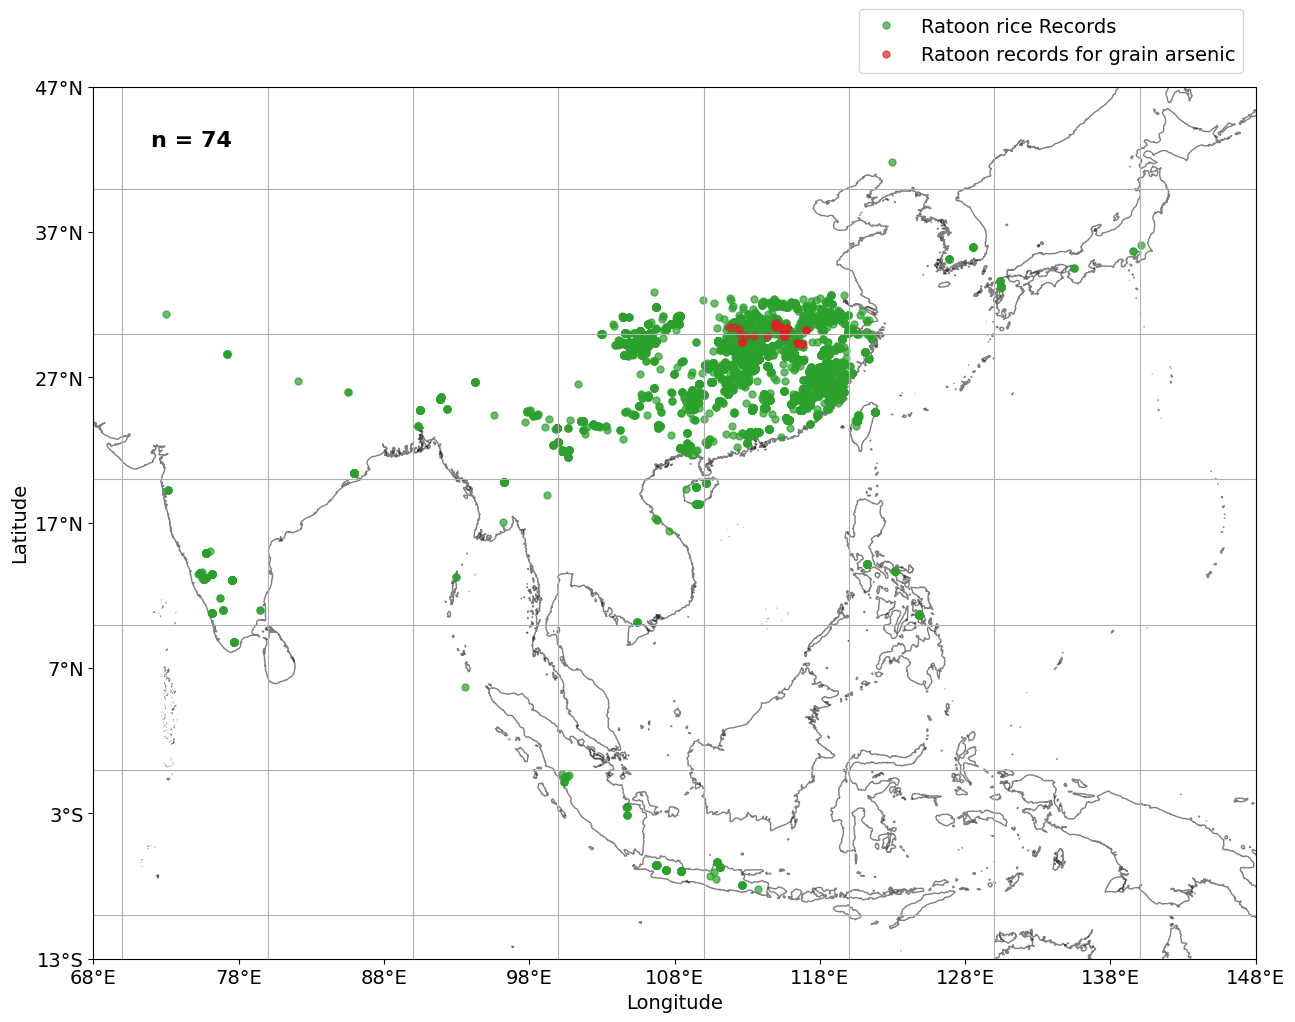

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

font_size = 14
#plt.style.use('seaborn')
# plt.rc('font', size=font_size)        # default text size (won't work)
plt.rc('axes', titlesize=font_size)   # title
plt.rc('axes', labelsize=font_size)   # x and y labels
plt.rc('xtick', labelsize=font_size)  # x tick labels
plt.rc('ytick', labelsize=font_size)  # y tick labels
plt.rc('legend', fontsize=font_size)  # legend
plt.rc('lines', markersize=10)    
plt.rc('lines', linewidth =1.5) 

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Load the CSV datasets
data_records = pd.read_csv(r'C:\Users\zhang\seadrive_root\Sha.Zhan\My Libraries\aPhD Papers\热浪\ratoon rice area\ratoon_records.csv',low_memory=False)
data_literature = pd.read_csv(r'C:\Users\zhang\Documents\A Heat waves python code\ratoon arsenic literature\ratoon arsenic_literature.csv',low_memory=False)

# Extract Longitude and Latitude data from both datasets
lon_records = data_records["lon"].values
lat_records = data_records["lat"].values

lon_literature = data_literature["lon"].values
lat_literature = data_literature["lat"].values

# Define lon and lat ranges
lon_range_records = (lon_records >= 61) & (lon_records <= 153)
lat_range_records = (lat_records >= -20) & (lat_records <= 54)

# Filter lon and lat data based on the specified ranges for records data
lon_records = lon_records[lon_range_records & lat_range_records]
lat_records = lat_records[lon_range_records & lat_range_records]

# Calculate the extent of the map with some padding
lon_min = 68  # Specified range
lon_max = 148
lat_min = -13
lat_max = 47

# Create a map plot with markers for lon and lat
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())

# Set the x and y ticks at intervals of 10 degrees
ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 10), crs=ccrs.PlateCarree())

# Set the x and y tick labels with degree symbols
ax.set_xticklabels([f'{x:.0f}°E' for x in ax.get_xticks()])
ax.set_yticklabels([f'{y:.0f}°N' if y >= 0 else f'{abs(y):.0f}°S' for y in ax.get_yticks()])

# Make coastlines transparent by setting their alpha (transparency) level
ax.coastlines(resolution='10m', alpha=0.5)

# Plot the records lon and lat data points
ax.plot(lon_records, lat_records, 'o', markersize=5, alpha=0.7, 
        color='tab:green', transform=ccrs.PlateCarree(), label='Ratoon rice Records')

# Plot the literature lon and lat data points with a different color
ax.plot(lon_literature, lat_literature, 'o', markersize=5, alpha=0.7, 
        color='tab:red', transform=ccrs.PlateCarree(), label='Ratoon records for grain arsenic')

# Add gridlines without labels
gl = ax.gridlines(draw_labels=False)

# Set the title and labels
# Set the title and labels
ax.text(0.05, 0.95, 'n = 74', transform=ax.transAxes, 
        fontsize=16, fontweight='bold', va='top', ha='left')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show legend
# Add legend outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(0.65, 1.1), fontsize=14)

# Show the plo
plt.savefig('arsenic_sampling_locations_map.tif', dpi=300, bbox_inches='tight')
plt.show()

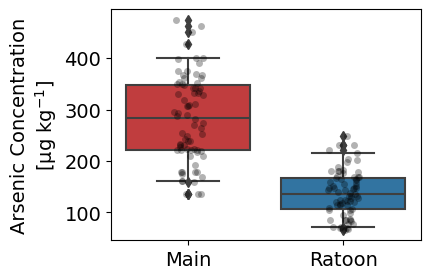

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

font_size = 14

# Set the font sizes for the plot
plt.rc('axes', titlesize=font_size)   # title
plt.rc('axes', labelsize=font_size)   # x and y labels
plt.rc('xtick', labelsize=font_size)  # x tick labels
plt.rc('ytick', labelsize=font_size)  # y tick labels
plt.rc('legend', fontsize=font_size)  # legend
plt.rc('lines', markersize=10)    
plt.rc('lines', linewidth =1.5) 

# Load the data from the CSV file
file_path = r'C:\Users\zhang\Documents\A Heat waves python code\ratoon arsenic literature\ratoon arsenic_literature.csv'
df = pd.read_csv(file_path)

# Extract the relevant columns
marsenic = df['marsenic']
rarsenic = df['rarsenic']

# Create a DataFrame for plotting
data_to_plot = pd.DataFrame({
    'Arsenic Type': ['marsenic'] * len(marsenic) + ['rarsenic'] * len(rarsenic),
    'Concentration': list(marsenic) + list(rarsenic)
})

# Create the box-whisker plot with scatter plot overlaid
fig, ax = plt.subplots(figsize=(4, 3))

# Define colors for the treatments
box_colors = {'marsenic': 'tab:red', 'rarsenic': 'tab:blue'}
strip_colors = {'marsenic': 'black', 'rarsenic': 'black'}

# Create the box plot with specified colors
sns.boxplot(x='Arsenic Type', y='Concentration', data=data_to_plot, 
            ax=ax, whis=[5, 95], palette=box_colors)

# Add scatter plot with specified colors
sns.stripplot(x='Arsenic Type', y='Concentration', data=data_to_plot, 
              ax=ax, jitter=True, color='black', size=5, alpha=0.3)

# Set the title and labels
ax.set_ylabel('Arsenic Concentration\n[$\mathrm{\mu}$g kg$^{-1}$]')

# Customize tick labels
ax.set_xticklabels(['Main', 'Ratoon'])

# Hide x-axis title
ax.set_xlabel('')

# Show the plot
plt.savefig('box_whisker_plot_with_scatter.tif', dpi=300, bbox_inches='tight')
plt.show()


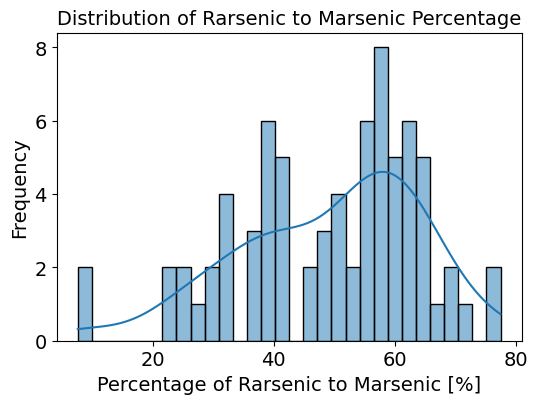

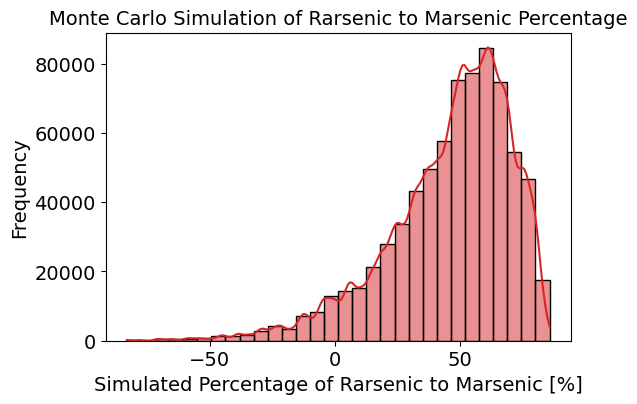

invalid value encountered in log
invalid value encountered in sqrt


Best fit distribution: beta
Best fit parameters: (42.5626925027164, 2.469210016278762, -654.0335346236045, 740.8352884760733)


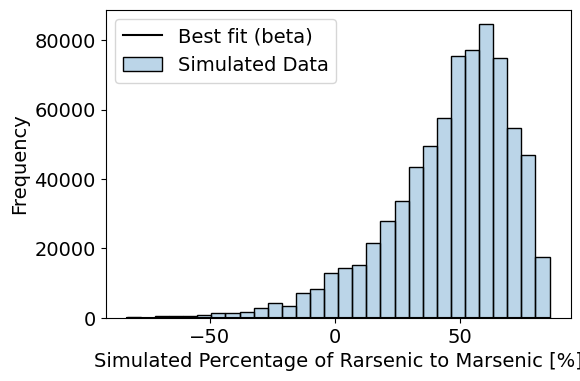

Median: 51.22%
Mean: 46.18%
Standard Deviation: 24.86%
5th Percentile: -2.62%
95th Percentile: 77.65%


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, skew, kurtosis

font_size = 14

# Set the font sizes for the plot
plt.rc('axes', titlesize=font_size)   # title
plt.rc('axes', labelsize=font_size)   # x and y labels
plt.rc('xtick', labelsize=font_size)  # x tick labels
plt.rc('ytick', labelsize=font_size)  # y tick labels
plt.rc('legend', fontsize=font_size)  # legend
plt.rc('lines', markersize=10)    
plt.rc('lines', linewidth =1.5) 

# Load the data from the CSV file
file_path = r'C:\Users\zhang\Documents\A Heat waves python code\ratoon arsenic literature\ratoon arsenic_literature.csv'
df = pd.read_csv(file_path)

# Extract the relevant columns
marsenic = df['marsenic']
rarsenic = df['rarsenic']

# Calculate the percentage of rarsenic to marsenic
percentage_rarsenic_to_marsenic =100- (rarsenic / marsenic) * 100

# Plot the distribution of the percentage of rarsenic to marsenic
plt.figure(figsize=(6, 4))
sns.histplot(percentage_rarsenic_to_marsenic, bins=30, kde=True, color='tab:blue')
plt.xlabel('Percentage of Rarsenic to Marsenic [%]')
plt.ylabel('Frequency')
plt.title('Distribution of Rarsenic to Marsenic Percentage')
plt.savefig('percentage_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Monte Carlo simulation
n_simulations = 10000
simulated_percentages = []

for _ in range(n_simulations):
    simulated_rarsenic = np.random.choice(rarsenic, size=len(rarsenic), replace=True)
    simulated_marsenic = np.random.choice(marsenic, size=len(marsenic), replace=True)
    simulated_percentage = (1-simulated_rarsenic / simulated_marsenic) * 100
    simulated_percentages.extend(simulated_percentage)

# Convert to numpy array for easier manipulation
simulated_percentages = np.array(simulated_percentages)

# Plot the distribution of the Monte Carlo simulated percentages
plt.figure(figsize=(6, 4))
sns.histplot(simulated_percentages, bins=30, kde=True, color='tab:red')
plt.xlabel('Simulated Percentage of Rarsenic to Marsenic [%]')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of Rarsenic to Marsenic Percentage')
plt.savefig('monte_carlo_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Fit various distributions to the simulated data
distributions = [stats.norm, stats.lognorm, stats.gamma, stats.beta, stats.expon, stats.weibull_min]
best_fit_name = None
best_fit_params = None
best_aic = np.inf

for distribution in distributions:
    params = distribution.fit(simulated_percentages)
    aic = 2 * len(params) - 2 * distribution.logpdf(simulated_percentages, *params).sum()
    if aic < best_aic:
        best_aic = aic
        best_fit_name = distribution.name
        best_fit_params = params

# Print the best fit distribution and its parameters
print(f"Best fit distribution: {best_fit_name}")
print(f"Best fit parameters: {best_fit_params}")

# Plot the best fit distribution over the histogram
plt.figure(figsize=(6, 4))
sns.histplot(simulated_percentages, bins=30, kde=False, color='tab:blue', 
             label='Simulated Data', alpha=0.3)

# Generate PDF values for the best fit distribution
x = np.linspace(simulated_percentages.min(), simulated_percentages.max(), 1000)
best_fit_dist = getattr(stats, best_fit_name)
pdf_values = best_fit_dist.pdf(x, *best_fit_params)

plt.plot(x, pdf_values, 'k-', label=f'Best fit ({best_fit_name})')
plt.xlabel('Simulated Percentage of Rarsenic to Marsenic [%]')
plt.ylabel('Frequency')
#plt.title('Best Fit Distribution for Simulated Data')
plt.legend()
plt.savefig('best_fit_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print statistical parameters for the best fit distribution
median_value = np.median(simulated_percentages)
mean_value = np.mean(simulated_percentages)
std_deviation = np.std(simulated_percentages)
percentile_5th = np.percentile(simulated_percentages, 5)
percentile_95th = np.percentile(simulated_percentages, 95)

print(f"Median: {median_value:.2f}%")
print(f"Mean: {mean_value:.2f}%")
print(f"Standard Deviation: {std_deviation:.2f}%")
print(f"5th Percentile: {percentile_5th:.2f}%")
print(f"95th Percentile: {percentile_95th:.2f}%")


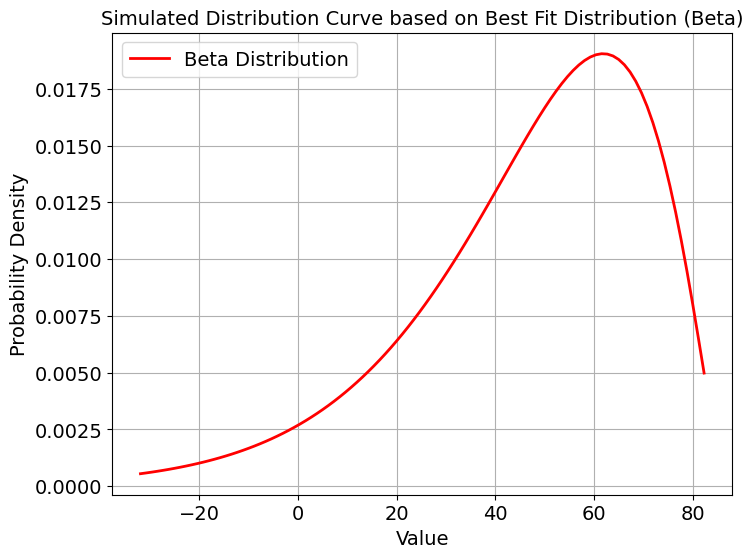

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Best fit parameters
a = 88.69285281059733
b = 2.5413946977797437
loc = -1369.002506594864
scale = 1455.9403026831887

# Generate data points for x-axis
x = np.linspace(beta.ppf(0.01, a, b, loc=loc, scale=scale),
                beta.ppf(0.99, a, b, loc=loc, scale=scale), 100)

# Generate distribution curve based on best fit parameters
pdf = beta.pdf(x, a, b, loc=loc, scale=scale)

# Plot the distribution curve
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, 'r-', lw=2, label='Beta Distribution')
plt.title('Simulated Distribution Curve based on Best Fit Distribution (Beta)')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()


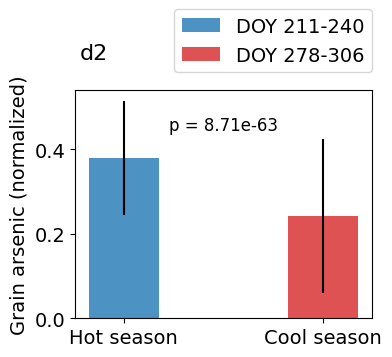

Mean ratio: 0.2873571588260875
Median ratio: 0.47538074638014616
Standard deviation of ratios: 0.6046294522769194
Percentiles of ratios: [0.03297782 0.47538075 0.72451422]


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Read the CSV file into a DataFrame
file_path = 'Seasonal pattern of grian rice arsenic.csv'
data = pd.read_csv(file_path)

# Filter out data for 'Faridpur, Bangladesh'
filtered_data = data[data['location'] != 'Faridpur, Bangladesh']

# Selecting the feature and dropping NaN values
selected_data_main = filtered_data[['DOY_harvest', 'grain_As_mean_standardized_removing_max_min']].dropna()

# Selecting data within specified ranges of days of year (DOY)
selected_data_range1 = selected_data_main[(selected_data_main['DOY_harvest'] >= 211) & (selected_data_main['DOY_harvest'] <= 240)]
selected_data_range2 = selected_data_main[(selected_data_main['DOY_harvest'] >= 278) & (selected_data_main['DOY_harvest'] <= 306)]

# Calculate mean and standard deviation for each range
mean_sd_range1 = selected_data_range1['grain_As_mean_standardized_removing_max_min'].mean()
std_range1 = selected_data_range1['grain_As_mean_standardized_removing_max_min'].std()

mean_sd_range2 = selected_data_range2['grain_As_mean_standardized_removing_max_min'].mean()
std_range2 = selected_data_range2['grain_As_mean_standardized_removing_max_min'].std()

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(4, 4))

bar_width = 0.35
index = np.arange(2)
opacity = 0.8

rects1 = ax.bar(index, [mean_sd_range1, mean_sd_range2], bar_width, alpha=opacity, color=['tab:blue', 'tab:red'], label=['DOY 211-240', 'DOY 278-306'], yerr=[std_range1, std_range2])

#ax.set_xlabel('Range of Days of Year (DOY)')
ax.set_ylabel('Grain arsenic (normalized)')
#ax.set_title('Normalized Grain Arsenic Concentration within Specific DOY Ranges')
ax.set_xticks(index)
ax.set_xticklabels(['Hot season', 'Cool season'])
ax.legend(loc='upper left', bbox_to_anchor=(0.3, 1.4))
from scipy.stats import ttest_ind

# Extracting the data for each range
data_range1 = selected_data_range1['grain_As_mean_standardized_removing_max_min']
data_range2 = selected_data_range2['grain_As_mean_standardized_removing_max_min']

# Performing independent samples t-test
t_stat, p_value = ttest_ind(data_range1, data_range2)

# Adding text for p-value
ax.text(0.5, 0.85, f'p = {p_value:.2e}', horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes, fontsize=12)


plt.tight_layout()

ax.text(-0.15, 0.65, f"d2", ha='center', va='top', bbox=dict(facecolor='white', edgecolor='none'), fontsize=16)

# Save and show the plot
plt.savefig('grain_arsenic_reduction_late_season.tiff', dpi=600, bbox_inches='tight')

plt.show()

import numpy as np

# Resample data in range 1 to match the length of range 2
resampled_data_range1 = selected_data_range1.sample(n=len(selected_data_range2), replace=True, random_state=42)

# Calculate the ratio of each data point in range 2 to each corresponding data point in the resampled range 1
ratios = 1 - selected_data_range2['grain_As_mean_standardized_removing_max_min'].values / resampled_data_range1['grain_As_mean_standardized_removing_max_min'].values

# Calculate mean, median, standard deviation, and percentiles of the ratios
mean_ratio = np.mean(ratios)
median_ratio = np.median(ratios)
std_ratio = np.std(ratios)
percentiles_ratio = np.percentile(ratios, [25, 50, 75])

print("Mean ratio:", mean_ratio)
print("Median ratio:", median_ratio)
print("Standard deviation of ratios:", std_ratio)
print("Percentiles of ratios:", percentiles_ratio)

In [86]:
# Define parameters
num_simulations = 10000

# Initialize an array to store ratios from each simulation
simulated_ratios = []

# Mean and standard deviation of the resampled data from range 1
resampled_mean = resampled_data_range1['grain_As_mean_standardized_removing_max_min'].mean()
resampled_std = resampled_data_range1['grain_As_mean_standardized_removing_max_min'].std()

# Monte Carlo simulation
for _ in range(num_simulations):
    # Generate random samples from a normal distribution with resampled mean and standard deviation
    random_samples = np.random.normal(resampled_mean, resampled_std, len(selected_data_range2))
    
    # Calculate the ratio for each sample
    ratio = 1 - selected_data_range2['grain_As_mean_standardized_removing_max_min'].values / random_samples
    
    # Append the ratio to the list of simulated ratios
    simulated_ratios.append(ratio)

# Convert simulated_ratios to a NumPy array
simulated_ratios = np.array(simulated_ratios)

# Calculate mean, median, standard deviation, and percentiles of the simulated ratios
mean_ratio_simulated = np.mean(simulated_ratios)
median_ratio_simulated = np.median(simulated_ratios)
std_ratio_simulated = np.std(simulated_ratios)
percentiles_ratio_simulated = np.percentile(simulated_ratios, [25, 50, 75])

print("Mean ratio (simulated):", mean_ratio_simulated)
print("Median ratio (simulated):", median_ratio_simulated)
print("Standard deviation of ratios (simulated):", std_ratio_simulated)
print("Percentiles of ratios (simulated):", percentiles_ratio_simulated)


Mean ratio (simulated): 0.27953412853852944
Median ratio (simulated): 0.47085794628522437
Standard deviation of ratios (simulated): 43.66681279853374
Percentiles of ratios (simulated): [0.03119348 0.47085795 0.72283427]


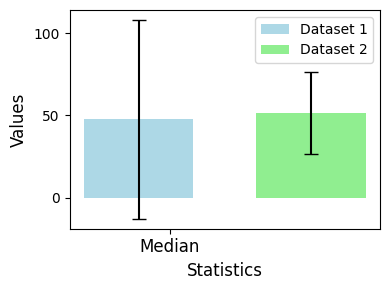

In [101]:
import matplotlib.pyplot as plt

# Data for the two datasets
labels = ['Median']
dataset1_values = [51.22]
dataset2_values = [47.53807464]

# Standard deviation for error bars
std_dataset1 = [24.86]
std_dataset2 = [60.46294523]

# Define the bar width and spacing
bar_width = 0.35
bar_space = 0.35

# Plotting
plt.figure(figsize=(4, 3))

# Plotting bars for dataset 1
plt.bar([0.9], dataset2_values, yerr=std_dataset2, width=bar_width, color='lightblue', 
        label='Dataset 1', align='center', capsize=5)

# Plotting bars for dataset 2
plt.bar([1.1 + bar_space], dataset1_values, yerr=std_dataset1, width=bar_width, 
        color='lightgreen', label='Dataset 2', align='center', capsize=5)

# Adding labels and title
plt.xlabel('Statistics', fontsize=12)
plt.ylabel('Values', fontsize=12)
#plt.title('Comparison of Median with Standard Deviation as Error Bars', fontsize=14)
plt.xticks([1], labels, fontsize=12)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

# Display plot
plt.grid(False)
plt.tight_layout()
plt.show()


In [98]:
from scipy.stats import ttest_ind
import numpy as np

# Sample size
n = 1000

# Generate random samples for the two datasets based on the provided median and standard deviation
np.random.seed(42)  # Setting a seed for reproducibility
dataset1_samples = np.random.normal(loc=51.22, scale=24.86, size=n)
dataset2_samples = np.random.normal(loc=47.53807464, scale=60.46294523, size=n)

# Perform t-test
t_statistic, p_value = ttest_ind(dataset1_samples, dataset2_samples)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: -0.05856501734871849
P-value: 0.9533044314430558
